<a id="unsequa-a-module-for-uncertainty-and-sensitivity-analysis"></a>
# Unsequa - a module for uncertainty and sensitivity analysis


This is a tutorial for the unsequa module in CLIMADA. A detailled description can be found in [Kropf (2021)](https://eartharxiv.org/repository/view/3123/).

<a id="uncertainty-and-sensitivity-analysis"></a>
## Uncertainty and sensitivity analysis


Before doing an uncertainty quantification in CLIMADA, it is imperative that you get first comfortable with the different notions of uncertainty in the modelling world (see e.g.[Pianosi (2016)](https://www.sciencedirect.com/science/article/pii/S1364815216300287) or [Douglas-Smith(2020)](https://doi.org/10.1007/978-1-4899-7547-8_5) for a review). In particular, note that the uncertaintity values will only be as good as the input from the user. In addition, not all uncertainties can be numerically quantified, and even worse, some unkonwns are unknown. This means that sometimes, quantifying uncertainty can lead to false confidence in the output!. For a more philosophical discussion about the types of uncertainties in climate research see [Knüsel (2020)](https://www.research-collection.ethz.ch/handle/20.500.11850/399735) and [Otth (2022)](https://gmd.copernicus.org/articles/15/7177/2022).

In this module, it is possible to perform global uncertainty analysis, as well as a sensitivity analysis. The word global is meant as opposition to the 'one-factor-at-a-time' (OAT) strategy. The OAT strategy, which consists in analyzing the effect of varying one model input factor at a time while keeping all other fixed, is popular among modellers, but has major shortcomings [Saltelli (2010)](https://www.sciencedirect.com/science/article/abs/pii/S1364815210001180), [Saltelli(2019)](http://www.sciencedirect.com/science/article/pii/S1364815218302822) and should not be used.

A rough schemata of how to perform uncertainty and sensitivity analysis (taken from [Kropf(2021)](https://eartharxiv.org/repository/view/3123/))

<img src="./img/UncertaintySensitivity.jpg" alt="Uncertainty and Sensitivity analysis" width="1000">

1. [Kropf, C.M. et al. Uncertainty and sensitivity analysis for global probabilistic weather and climate risk modelling: an implementation in the CLIMADA platform (2021)](https://eartharxiv.org/repository/view/3123/)
2. [Pianosi, F. et al. Sensitivity analysis of environmental models: A systematic review with practical workflow. Environmental Modelling & Software 79, 214–232 (2016)](https://www.sciencedirect.com/science/article/pii/S1364815216300287).
3.[Douglas-Smith, D., Iwanaga, T., Croke, B. F. W. & Jakeman, A. J. Certain trends in uncertainty and sensitivity analysis: An overview of software tools and techniques. Environmental Modelling & Software 124, 104588 (2020)](https://doi.org/10.1007/978-1-4899-7547-8_5)
4. [Knüsel, B. Epistemological Issues in Data-Driven Modeling in Climate Research. (ETH Zurich, 2020)](https://www.research-collection.ethz.ch/handle/20.500.11850/399735)
5. [Saltelli, A. et al. Why so many published sensitivity analyses are false: A systematic review of sensitivity analysis practices. Environmental Modelling & Software 114, 29–39 (2019)](http://www.sciencedirect.com/science/article/pii/S1364815218302822)
6. [Saltelli, A. & Annoni, P. How to avoid a perfunctory sensitivity analysis. Environmental Modelling & Software 25, 1508–1517 (2010)](https://www.sciencedirect.com/science/article/abs/pii/S1364815210001180)

<a id="unsequa-module-structure"></a>
## Unsequa Module Structure


The unsequa module contains several key classes. 

The model input parameters and their distribution are specified as
- `InputVar`: defines input uncertainty variables

The input parameter sampling, Monte-Carlo uncertainty distribution calculation and the sensitivity index computation are done in
- `CalcImpact`: compute uncertainties for outputs of `climada.engine.impact.calc` (child class of `Calc`)
- `CalcDeltaImpact`: compute uncertainties for outputs of `climada.engine.impact.calc` (child class of `Calc`)
- `CalcCostBenefit`: compute uncertainties for outputs of `climada.engine.cost_benefit.calc` (child class of `Calc`)

The results are stored in
- `UncOutput`: store the uncertainty and sensitivity analysis results. Contains also several plotting methods. This is a class which only stores data.
- `UncImpactOutput`: subclass with dataframes specifically for `climada.engine.impact.calc` uncertainty and sensitivity analysis results.
- `UncCostBenefitOutput`: subclass with dataframes specifically for `climada.engine.cost_benefit.calc` uncertainty and sensitivity analysis results.

<a id="inputvar"></a>
## InputVar


The InputVar class is used to define uncertainty variables. 

| Attribute | Type | Description |
| --- | --- | --- |
| func | function | Model variable defined as a function of the uncertainty input parameters |
| distr_dict | dict | Dictionary of the probability density distributions of the uncertainty input parameters |

An **input uncertainty parameter** is a numerical input value that has a certain probability density distribution in your model, such as the total exposure asset value, the slope of the vulnerability function, the exponents of the litpop exposure,  the value of the discount rate, the cost of an adaptation measure, ... 

The probability densitity distributions (values of `distr_dict`) of the input uncertainty parameters (keyword arguments of the `func` and keys of the `distr_dict`) can be any of the ones defined in [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html).

 **Several helper methods exist to make generic InputVar for Exposures, ImpactFuncSet, Hazard, Entity (including DiscRates and Measures)**. These are described in details in the tutorial [Helper methods for InputVar](climada_engine_unsequa_helper.ipynb). These are a good bases for your own computations.

<a id="example-custom-continuous-uncertainty-parameter"></a>
### Example - custom continuous uncertainty parameter


Suppose we assume that the GDP value used to scale the exposure has a relative error of +-10%. 

In [1]:
import warnings

warnings.filterwarnings("ignore")  # Ignore warnings for making the tutorial's pdf.

# Define the base exposure
from climada.util.constants import EXP_DEMO_H5
from climada.entity import Exposures

exp_base = Exposures.from_hdf5(EXP_DEMO_H5)

In [2]:
# Define the function that returns an exposure with scaled total assed value
# Here x_exp is the input uncertainty parameter and exp_func the inputvar.func.
def exp_func(x_exp, exp_base=exp_base):
    exp = exp_base.copy()
    exp.gdf["value"] *= x_exp
    return exp

In [3]:
# Define the Uncertainty Variable with +-10% total asset value
# The probability density distribution of the input uncertainty parameter x_exp is sp.stats.uniform(0.9, 0.2)
from climada.engine.unsequa import InputVar
import scipy as sp

exp_distr = {
    "x_exp": sp.stats.uniform(0.9, 0.2),
}
exp_iv = InputVar(exp_func, exp_distr)

In [4]:
# Uncertainty parameters
exp_iv.labels

['x_exp']

In [5]:
# Evaluate for a given value of the uncertainty parameters
exp095 = exp_iv.func(x_exp=0.95)
print(
    f"Base value is {exp_base.gdf['value'].sum()}, and the value for x_exp=0.95 is {exp095.gdf['value'].sum()}"
)

Base value is 657053294559.9105, and the value for x_exp=0.95 is 624200629831.9148


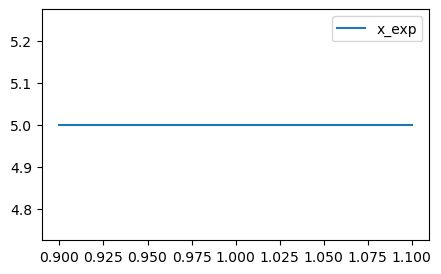

In [6]:
# Defined distribution
exp_iv.plot(figsize=(5, 3));

<a id="example-custom-categorical-uncertainty-parameter"></a>
### Example - custom categorical uncertainty parameter


Suppose we want to test different exponents (m=1,2 ; n=1,2) for the LitPop exposure for the country Switzerland.

In [7]:
from climada.entity import LitPop

m_min, m_max = (1, 2)
n_min, n_max = (1, 2)


# Define the function
# Note that this here works, but might be slow because the method LitPop is called everytime the the function
# is evaluated, and LitPop is relatively slow.
def litpop_cat(m, n):
    exp = Litpop.from_countries("CHE", res_arcsec=150, exponent=[m, n])
    return exp

In [8]:
# A faster method would be to first create a dictionnary with all the exposures. This however
# requires more memory and precomputation time (here ~3-4mins)
exp = LitPop()
litpop_dict = {}
for m in range(m_min, m_max + 1):
    for n in range(n_min, n_max + 1):
        exp_mn = LitPop.from_countries("CHE", res_arcsec=150, exponents=[m, n])
        litpop_dict[(m, n)] = exp_mn


def litpop_cat(m, n, litpop_dict=litpop_dict):
    return litpop_dict[(m, n)]

In [9]:
# Define the distribution dictionnary
import scipy as sp
from climada.engine.unsequa import InputVar

distr_dict = {
    "m": sp.stats.randint(low=m_min, high=m_max + 1),
    "n": sp.stats.randint(low=n_min, high=n_max + 1),
}

cat_iv = InputVar(
    litpop_cat, distr_dict
)  # One can use either of the above definitions of litpop_cat

In [10]:
# Uncertainty parameters
cat_iv.labels

['m', 'n']

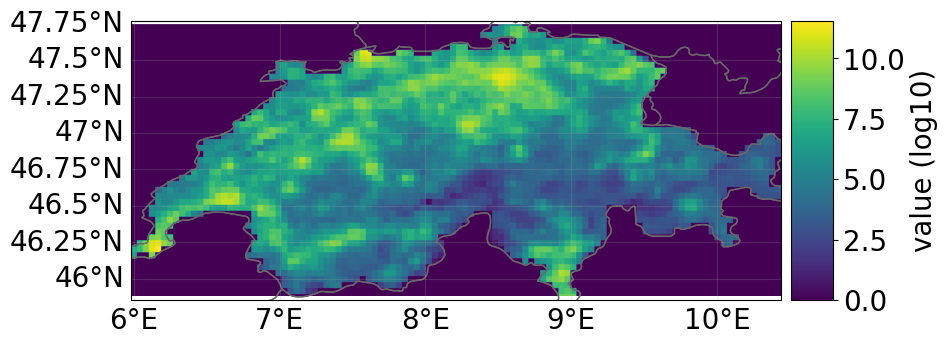

In [11]:
cat_iv.evaluate(m=1, n=2).plot_raster();

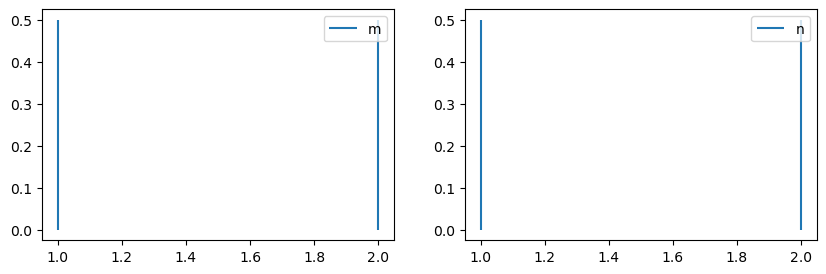

In [12]:
cat_iv.plot(figsize=(10, 3));

<a id="uncoutput"></a>
## UncOutput


The `UncOutput` class is used to store data from sampling, uncertainty and sensitivity analysis. An UncOutput object can be saved and loaded from .hdf5. The classes `UncImpactOuput` and `UncCostBenefitOutput` are extensions of `UncOutput` specific for `CalcImpact` and `CalcCostBenefit`, respectively.

**Data attributes**

| Attribute | Type | Description |
| --- | --- | --- |
| samples_df | pandas.dataframe | Each row represents a sample obtained from the input parameters (one per column) distributions |
| | | |
| *UncImpactOutput* | |  |
| | | |
| aai_agg_unc_df | pandas.dataframe | Uncertainty data for `aai_agg`|
| freq_curve_unc_df | pandas.dataframe | Uncertainty data for `freq_curve`. One return period per column.|
| eai_exp_unc_df | pandas.dataframe | Uncertainty data for `eai_exp`. One exposure point per column.|
| at_event_unc_df | pandas.dataframe | Uncertainty data for `at_event`. One event per column.|
| | | |
| *UncCostBenefitOutput* | |  |
| | | |
| imp_meas_present_unc_df | pandas.dataframe | Uncertainty data for `imp_meas_present`. One measure per column.|
| imp_meas_future_unc_df| pandas.dataframe | Uncertainty data for `imp_meas_present`. One measure per column |
| tot_climate_risk_unc_df | pandas.dataframe | Uncertainty data for `tot_climate_risk`. One measure per column.|
| benefit_unc_df | pandas.dataframe | Uncertainty data for `benefit`. One measure per column.|
| cost_ben_ratio_unc_df | pandas.dataframe | Uncertainty data for `cost_ben_ratio`. One measure per column.|
| cost_benefit_kwargs | dictionary | Keyword arguments for `climada.engine.cost_benefit.calc`. |

**Metadata and input data attributes**

These attributes are used for book-keeping and characterize the sample, uncertainty and sensitivity data. These attributes are set by the methods from classes `CalcImpact` and `CalcCostBenefit` used to generate sample, uncertainty and sensitivity data.

| Attribute | Type | Description |
| --- | --- | --- |
| sampling_method | str | The sampling method as defined in [SALib](https://salib.readthedocs.io/en/latest/api.html). Possible choices: 'saltelli', 'fast_sampler', 'latin', 'morris', 'dgsm', 'ff'|
| sampling_kwargs | dict | Keyword arguments for the sampling_method. |
| n_samples | int | Effective number of samples (number of rows of samples_df)|
| param_labels | list(str) | Name of all the uncertainty input parameters|
| problem_sa | dict | The description of the uncertainty variables and their distribution as used in [SALib](https://salib.readthedocs.io/en/latest/basics.html). |
| sensitivity_method | str | Sensitivity analysis method from [SALib.analyse](https://salib.readthedocs.io/en/latest/api.html) Possible choices: 'fast', 'rbd_fact', 'morris', 'sobol', 'delta', 'ff'. Note that in Salib, sampling methods and sensitivity analysis methods should be used in specific pairs.|
| sensitivity_kwargs | dict | Keyword arguments for sensitivity_method. |
| unit | str | Unit of the exposures value |

<a id="example-from-file"></a>
### Example from file


Here we show an example loaded from file. In the sections below this class is extensively used and further examples can be found.

In [13]:
# Download the test file from the API
# Requires internet connection
from climada.util.constants import TEST_UNC_OUTPUT_IMPACT
from climada.util.api_client import Client

apiclient = Client()
ds = apiclient.get_dataset_info(name=TEST_UNC_OUTPUT_IMPACT, status="test_dataset")
_target_dir, [filename] = apiclient.download_dataset(ds)

In [14]:
# If you produced your own data, you do not need the API. Just replace 'filename' with the path to your file.
from climada.engine.unsequa import UncOutput

unc_imp = UncOutput.from_hdf5(filename)

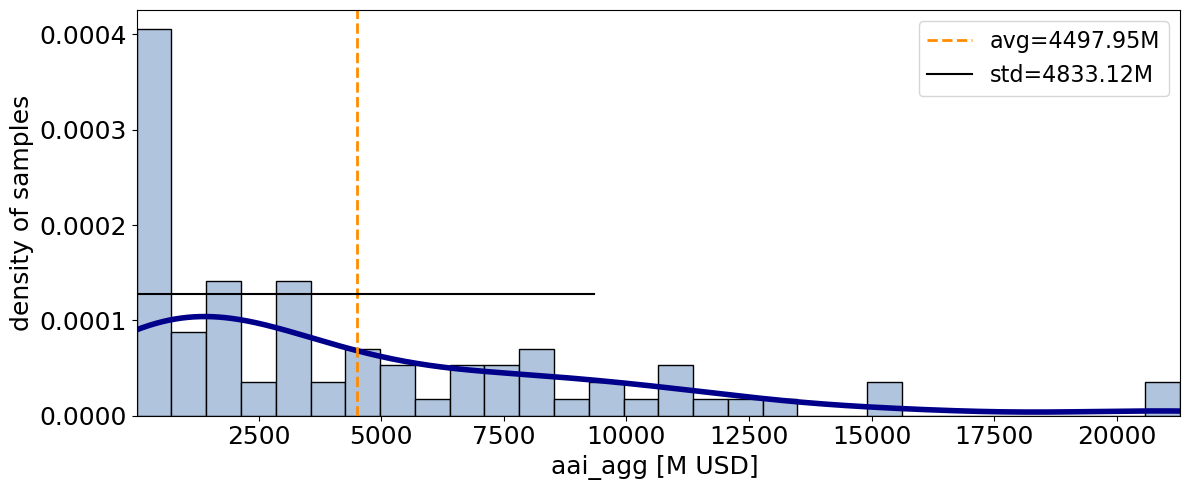

In [15]:
unc_imp.plot_uncertainty(metric_list=["aai_agg"], figsize=(12, 5));

In [16]:
# Download the test file from the API
# Requires internet connection
from climada.util.constants import TEST_UNC_OUTPUT_COSTBEN
from climada.util.api_client import Client

apiclient = Client()
ds = apiclient.get_dataset_info(name=TEST_UNC_OUTPUT_COSTBEN, status="test_dataset")
_target_dir, [filename] = apiclient.download_dataset(ds)

In [17]:
# If you produced your own data, you do not need the API. Just replace 'filename' with the path to your file.
from climada.engine.unsequa import UncOutput

unc_cb = UncOutput.from_hdf5(filename)

In [18]:
unc_cb.get_uncertainty().tail()

,Mangroves Benef,Beach nourishment Benef,Seawall Benef,Building code Benef,Mangroves CostBen,Beach nourishment CostBen,Seawall CostBen,Building code CostBen,no measure - risk - future,no measure - risk_transf - future,...,Beach nourishment - cost_ins - future,Seawall - risk - future,Seawall - risk_transf - future,Seawall - cost_meas - future,Seawall - cost_ins - future,Building code - risk - future,Building code - risk_transf - future,Building code - cost_meas - future,Building code - cost_ins - future,tot_climate_risk
35,2.375510e+08,1.932608e+08,234557.682554,1.584398e+08,6.347120,10.277239,4.350910e+04,66.742129,6.337592e+08,0.0,...,1,6.335246e+08,0,1.020539e+10,1,4.753194e+08,0,1.057461e+10,1,6.337592e+08
36,9.272772e+07,7.643803e+07,9554.257314,5.501366e+07,16.260133,25.984286,1.068151e+06,192.217876,2.200547e+08,0.0,...,1,2.200451e+08,0,1.020539e+10,1,1.650410e+08,0,1.057461e+10,1,2.200547e+08
37,1.464219e+08,1.179927e+08,192531.748810,8.979471e+07,10.297402,16.833137,5.300629e+04,117.764285,3.591788e+08,0.0,...,1,3.589863e+08,0,1.020539e+10,1,2.693841e+08,0,1.057461e+10,1,3.591788e+08
38,9.376369e+07,7.722882e+07,10681.112247,5.555413e+07,12.965484,20.736269,7.703765e+05,153.475031,2.222165e+08,0.0,...,1,2.222058e+08,0,8.228478e+09,1,1.666624e+08,0,8.526172e+09,1,2.222165e+08
39,9.376369e+07,7.722882e+07,10681.112247,5.555413e+07,16.080478,25.718218,9.554617e+05,190.347852,2.222165e+08,0.0,...,1,2.222058e+08,0,1.020539e+10,1,1.666624e+08,0,1.057461e+10,1,2.222165e+08


<a id="calcimpact"></a>
## CalcImpact


<a id="set-the-inputvars"></a>
### Set the InputVars


In this example, we model the impact function for tropical cyclones on the parametric function suggested in Emanuel (2015) with 4 parameters. The exposures total value varies between 80% and 120%. For that hazard, we assume to have no good error estimate and thus do not define an InputVar for the hazard.

In [19]:
# Define the input variable functions
import numpy as np

from climada.entity import ImpactFunc, ImpactFuncSet, Exposures
from climada.util.constants import EXP_DEMO_H5, HAZ_DEMO_H5
from climada.hazard import Hazard


def impf_func(G=1, v_half=84.7, vmin=25.7, k=3, _id=1):

    def xhi(v, v_half, vmin):
        return max([(v - vmin), 0]) / (v_half - vmin)

    def sigmoid_func(v, G, v_half, vmin, k):
        return G * xhi(v, v_half, vmin) ** k / (1 + xhi(v, v_half, vmin) ** k)

    # In-function imports needed only for parallel computing on Windows
    import numpy as np
    from climada.entity import ImpactFunc, ImpactFuncSet

    intensity_unit = "m/s"
    intensity = np.linspace(0, 150, num=100)
    mdd = np.repeat(1, len(intensity))
    paa = np.array([sigmoid_func(v, G, v_half, vmin, k) for v in intensity])
    imp_fun = ImpactFunc("TC", _id, intensity, mdd, paa, intensity_unit)
    imp_fun.check()
    impf_set = ImpactFuncSet([imp_fun])
    return impf_set


haz = Hazard.from_hdf5(HAZ_DEMO_H5)
exp_base = Exposures.from_hdf5(EXP_DEMO_H5)
# It is a good idea to assign the centroids to the base exposures in order to avoid repeating this
# potentially costly operation for each sample.
exp_base.assign_centroids(haz)


def exp_base_func(x_exp, exp_base):
    exp = exp_base.copy()
    exp.gdf["value"] *= x_exp
    return exp


from functools import partial

exp_func = partial(exp_base_func, exp_base=exp_base)

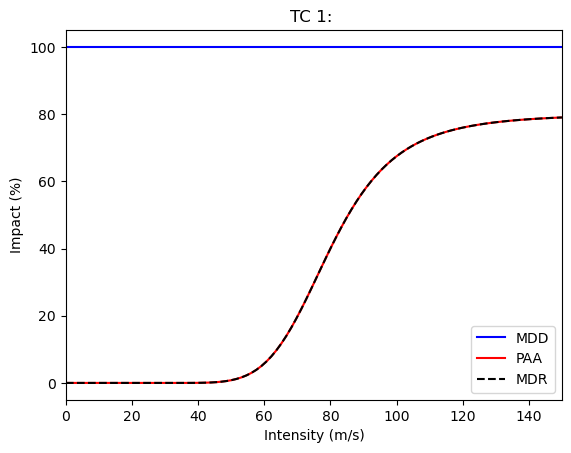

In [20]:
# Visualization of the parametrized impact function
impf_func(G=0.8, v_half=80, vmin=30, k=5).plot();

In [21]:
# Define the InputVars

import scipy as sp
from climada.engine.unsequa import InputVar

exp_distr = {
    "x_exp": sp.stats.beta(10, 1.1)
}  # This is not really a reasonable distribution but is used
# here to show that you can use any scipy distribution.

exp_iv = InputVar(exp_func, exp_distr)

impf_distr = {
    "G": sp.stats.truncnorm(0.5, 1.5),
    "v_half": sp.stats.uniform(35, 65),
    "vmin": sp.stats.uniform(0, 15),
    "k": sp.stats.uniform(1, 4),
}
impf_iv = InputVar(impf_func, impf_distr)

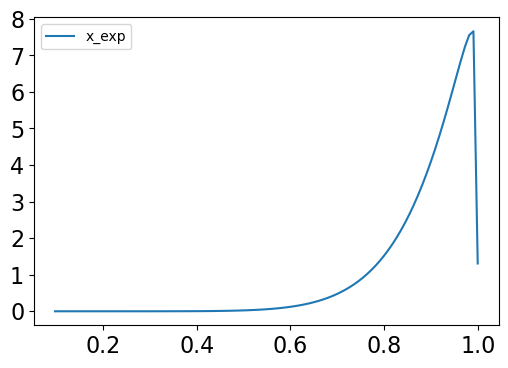

In [22]:
import matplotlib.pyplot as plt

ax = exp_iv.plot(figsize=(6, 4))
plt.yticks(fontsize=16)
plt.xticks(fontsize=16);

<a id="compute-uncertainty-and-sensitivity-using-default-methods"></a>
### Compute uncertainty and sensitivity using default methods


First, we define the UncImpact object with our uncertainty variables. 

In [23]:
from climada.engine.unsequa import CalcImpact

calc_imp = CalcImpact(exp_iv, impf_iv, haz)

Next, we generate samples for the uncertainty parameters using the default methods. Note that depending on the chosen Salib method, the effective number of samples differs from the input variable N. For the default 'saltelli', with `calc_second_order=True`, the effective number is N(2D+2), with D the number of uncertainty parameters. See [SAlib](https://salib.readthedocs.io/en/latest/api.html) for more information.

In [24]:
output_imp = calc_imp.make_sample(N=2**7, sampling_kwargs={"skip_values": 2**8})
output_imp.get_samples_df().tail()

,x_exp,G,v_half,vmin,k
1531,0.876684,1.242977,53.662109,2.080078,4.539062
1532,0.876684,0.790617,44.013672,2.080078,4.539062
1533,0.876684,0.790617,53.662109,13.681641,4.539062
1534,0.876684,0.790617,53.662109,2.080078,3.960938
1535,0.876684,0.790617,53.662109,2.080078,4.539062


The resulting samples can be visualized in plots.

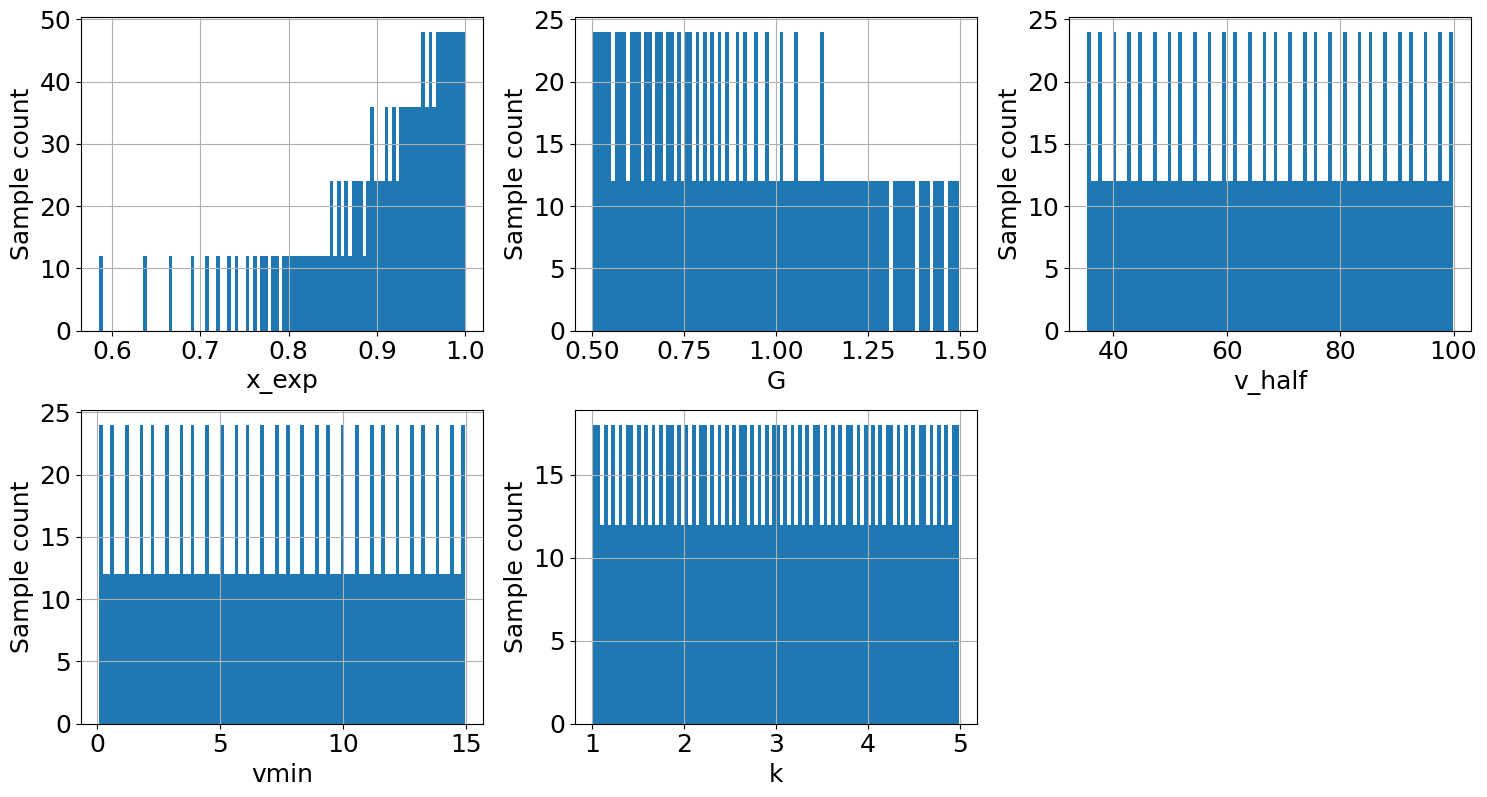

In [25]:
output_imp.plot_sample(figsize=(15, 8));

Now we can compute the value of the impact metrics for all the samples. In this example, we additionaly chose to restrict the return periods 50, 100, and 250 years. By default, `eai_exp` and `at_event` are not stored.

In [26]:
output_imp = calc_imp.uncertainty(output_imp, rp=[50, 100, 250])

The distributions of metrics ouputs are stored as dictionaries of pandas dataframe. The metrics are directly taken from the output of `climada.impact.calc`. For each metric, on dataframe is made.

In [27]:
# All the computed uncertainty metrics attribute
output_imp.uncertainty_metrics

['aai_agg', 'freq_curve']

In [28]:
# One uncertainty dataframe
output_imp.get_unc_df("aai_agg").tail()

,aai_agg
1531,2.905571e+09
1532,3.755172e+09
1533,1.063119e+09
1534,2.248718e+09
1535,1.848139e+09


Accessing the uncertainty is in general done via the method `get_uncertainty()`. If none are specified, all metrics are returned.

In [29]:
output_imp.get_uncertainty().tail()

,aai_agg,rp50,rp100,rp250
1531,2.905571e+09,8.324391e+10,1.162643e+11,1.510689e+11
1532,3.755172e+09,1.096005e+11,1.460838e+11,1.809413e+11
1533,1.063119e+09,2.892734e+10,4.720869e+10,6.807561e+10
1534,2.248718e+09,6.468855e+10,8.653474e+10,1.085266e+11
1535,1.848139e+09,5.294874e+10,7.395191e+10,9.609003e+10


The distributions of the one-dimensioanl metrics (`eai_exp` and `at_event` are never shown with this method) can be vizualised with plots.

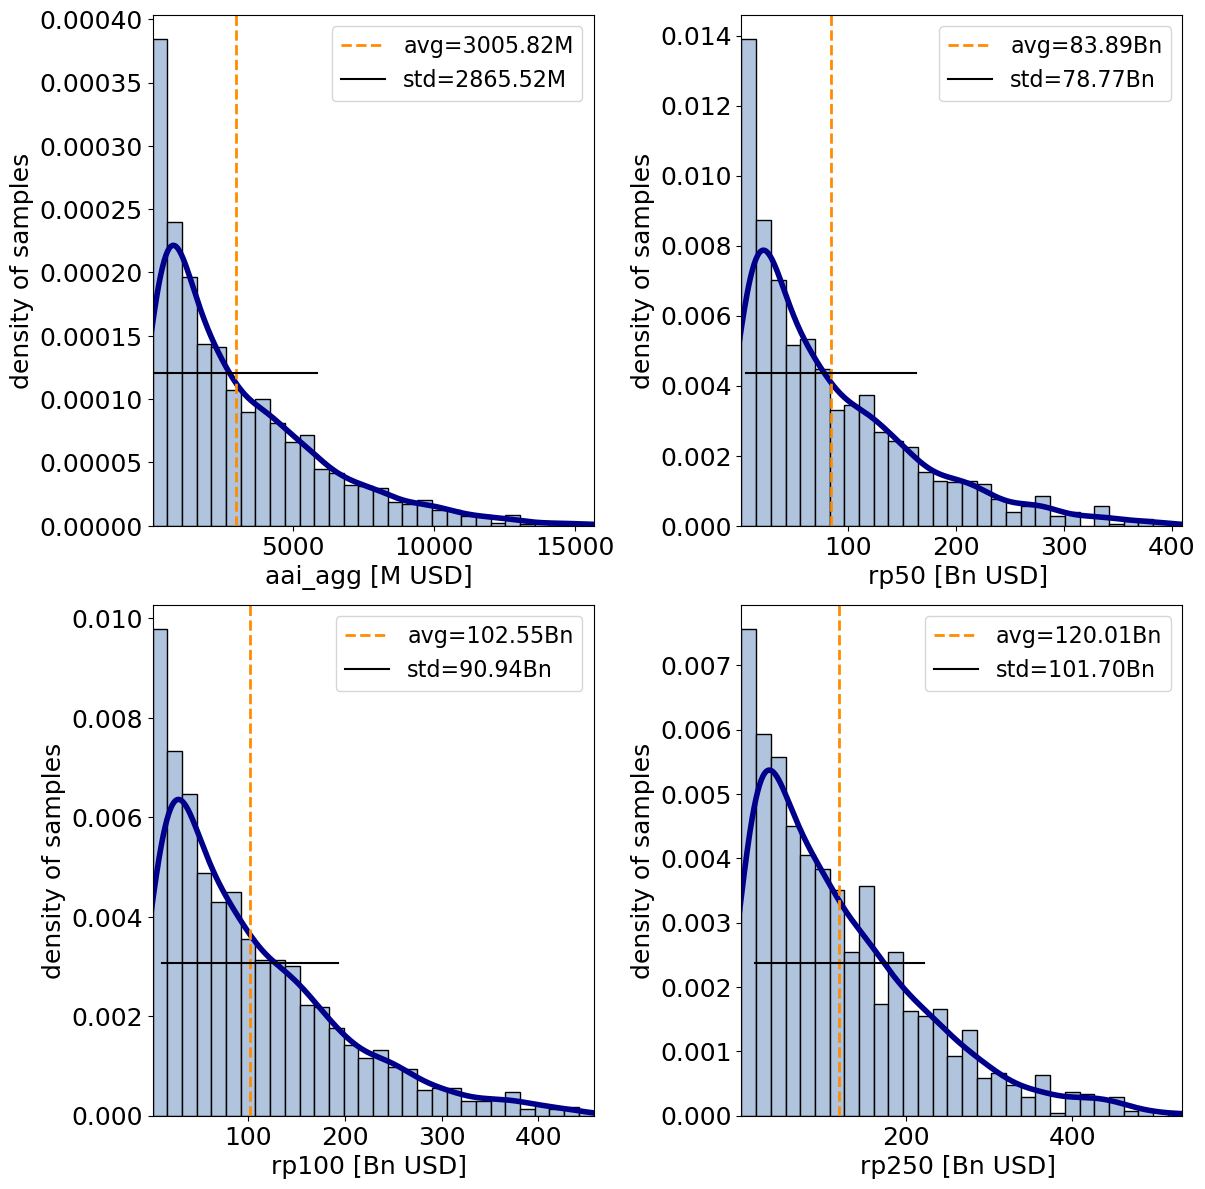

In [30]:
output_imp.plot_uncertainty(figsize=(12, 12));

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


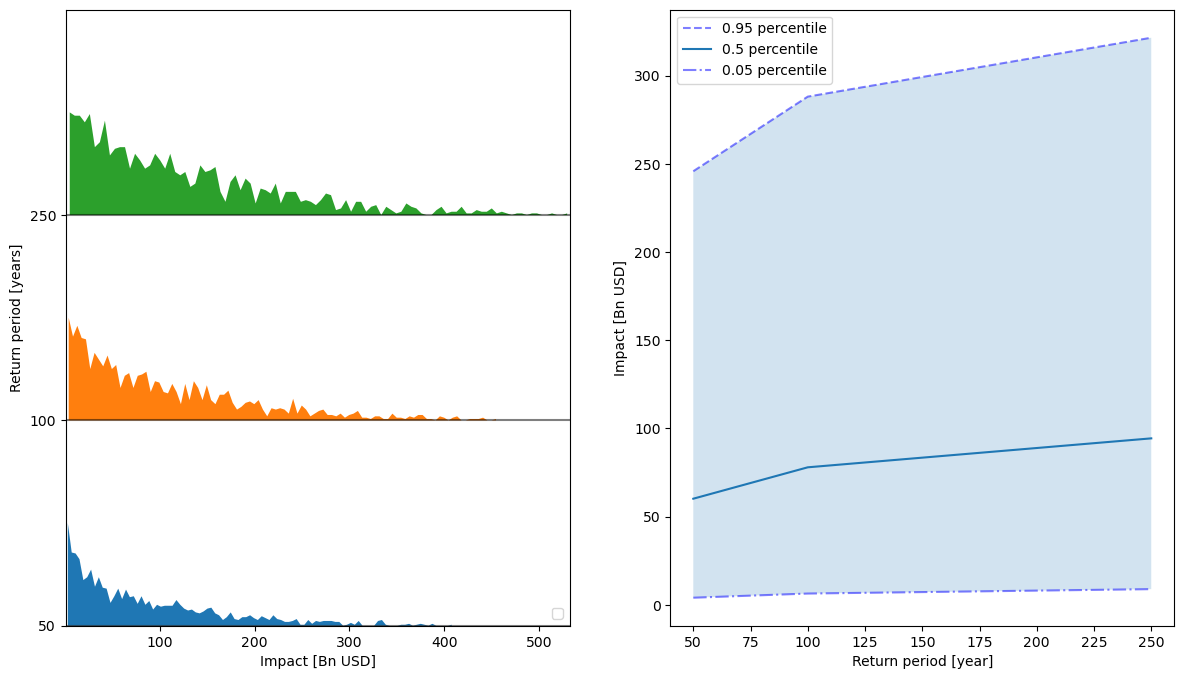

In [31]:
# Specific plot for the return period distributions
output_imp.plot_rp_uncertainty(figsize=(14.3, 8));

Now that a distribution of the impact metrics has been computed for each sample, we can also compute the sensitivity indices for each metrics to each uncertainty parameter. Note that the chosen method for the sensitivity analysis should correpond to its sampling partner as defined in the [SAlib](https://salib.readthedocs.io/en/latest/api.html) package.

The sensitivity indices dictionnaries outputs from the SAlib methods are stored in the same structure of nested dictionnaries as the metrics distributions. Note that depending on the chosen sensitivity analysis method the returned indices dictionnary will return specific types of sensitivity indices with specific names. Please get familiar with [SAlib](https://salib.readthedocs.io/en/latest/api.html) for more information.

Note that in our case, several of the second order sensitivity indices are negative. For the default method `sobol`, this indicates that the algorithm has not converged and cannot give realiable values for these sensitivity indices. If this happens, please use a larger number of samples. Here we will focus on the first-order indices.

In [32]:
output_imp = calc_imp.sensitivity(output_imp)

Similarly to the uncertainty case, the data is stored in dataframe attributes.

In [33]:
output_imp.sensitivity_metrics

['aai_agg', 'freq_curve']

In [34]:
output_imp.get_sens_df("aai_agg").tail()

,si,param,param2,aai_agg
65,S2_conf,k,x_exp,NaN
66,S2_conf,k,G,NaN
67,S2_conf,k,v_half,NaN
68,S2_conf,k,vmin,NaN
69,S2_conf,k,k,NaN


To obtain the sensitivity interms of a particular sensitivity index, use the method `get_sensisitivity()`. If none is specified, the value of the index for all metrics is returned.

In [35]:
output_imp.get_sensitivity("S1")

,si,param,param2,aai_agg,rp50,rp100,rp250
0,S1,x_exp,None,0.001040,0.000993,0.000930,0.001150
1,S1,G,None,0.073408,0.075781,0.084662,0.093718
2,S1,v_half,None,0.514220,0.553640,0.596659,0.619366
3,S1,vmin,None,0.012642,0.014407,0.012068,0.010065
4,S1,k,None,0.213491,0.189862,0.134867,0.095861


Sometimes, it is useful to simply know what is the largest sensitivity index for each metric.

In [36]:
output_imp.get_largest_si(salib_si="S1")

,metric,param,param2,si
0,aai_agg,v_half,None,0.514220
1,rp50,v_half,None,0.553640
2,rp100,v_half,None,0.596659
3,rp250,v_half,None,0.619366


The value of the sensitivity indices can be plotted for each metric that is one-dimensional (`eai_exp` and `at_event` are not shown in this plot). 

We see that both the errors in `freq_curve` and in `aai_agg` are mostly determined by `x_exp` and `v_half`. Finally, we see small differences in the sensitivity of the different return periods.

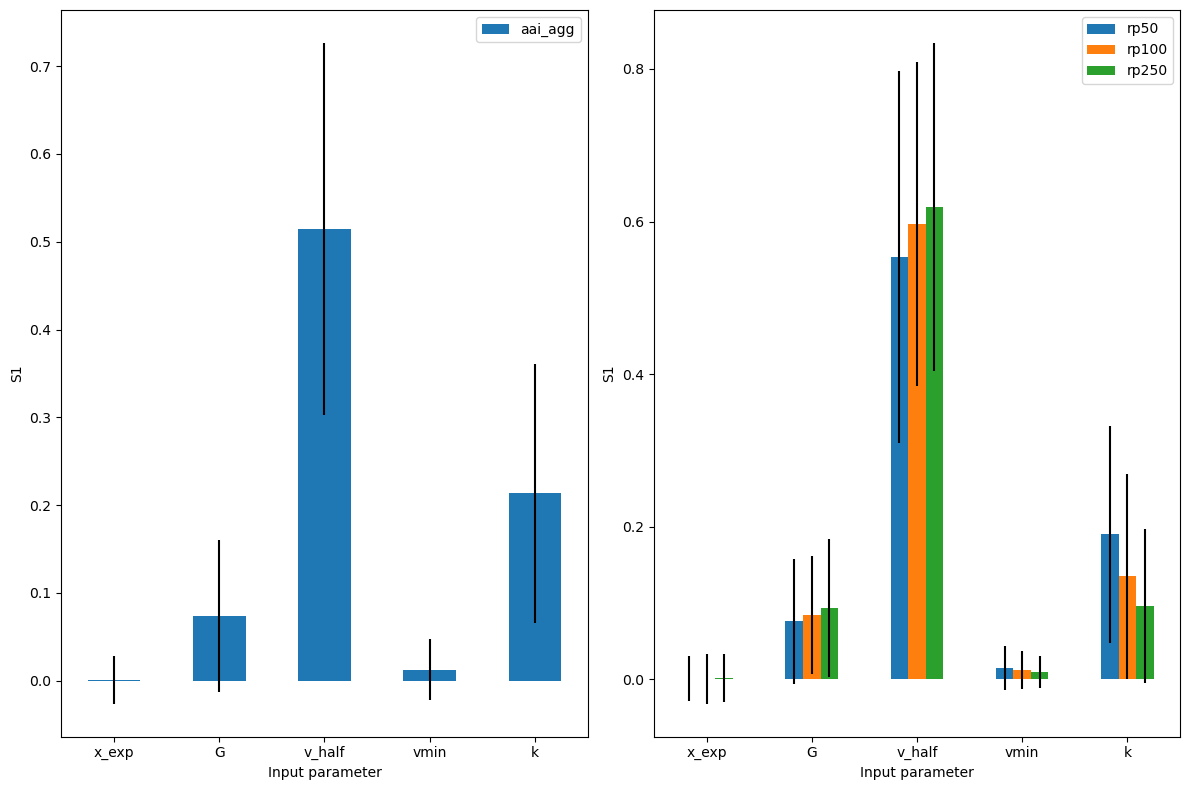

In [37]:
# Default for 'sobol' is to plot 'S1' sensitivity index.
output_imp.plot_sensitivity(figsize=(12, 8));

Note that since we have quite a few measures, the imp_meas_fut and imp_meas_pres plots are too crowded. We can select only the other metrics easily. In addition, instead of showing first order sensitivity 'S1', we can plot the total sensitivity 'ST'.

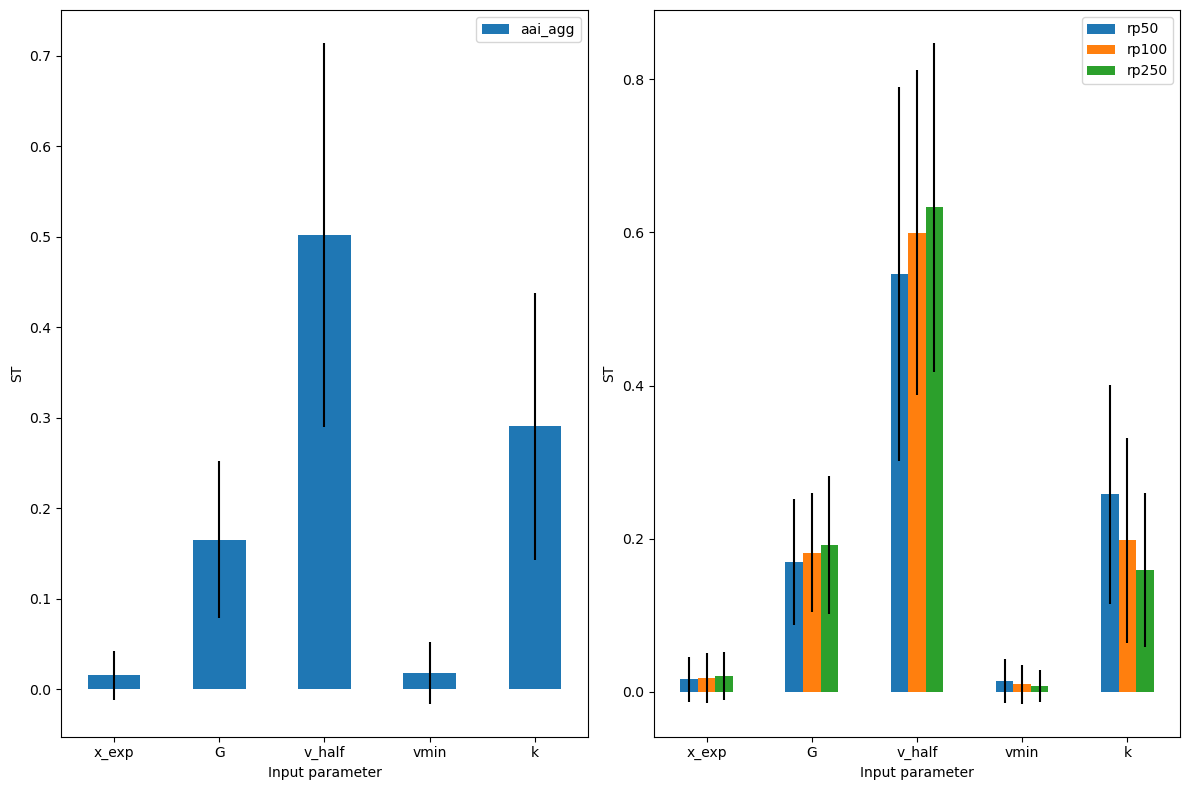

In [38]:
output_imp.plot_sensitivity(salib_si="ST", figsize=(12, 8));

One can also vizualise the second-order sensitivity indices in the form of a correlation matrix.

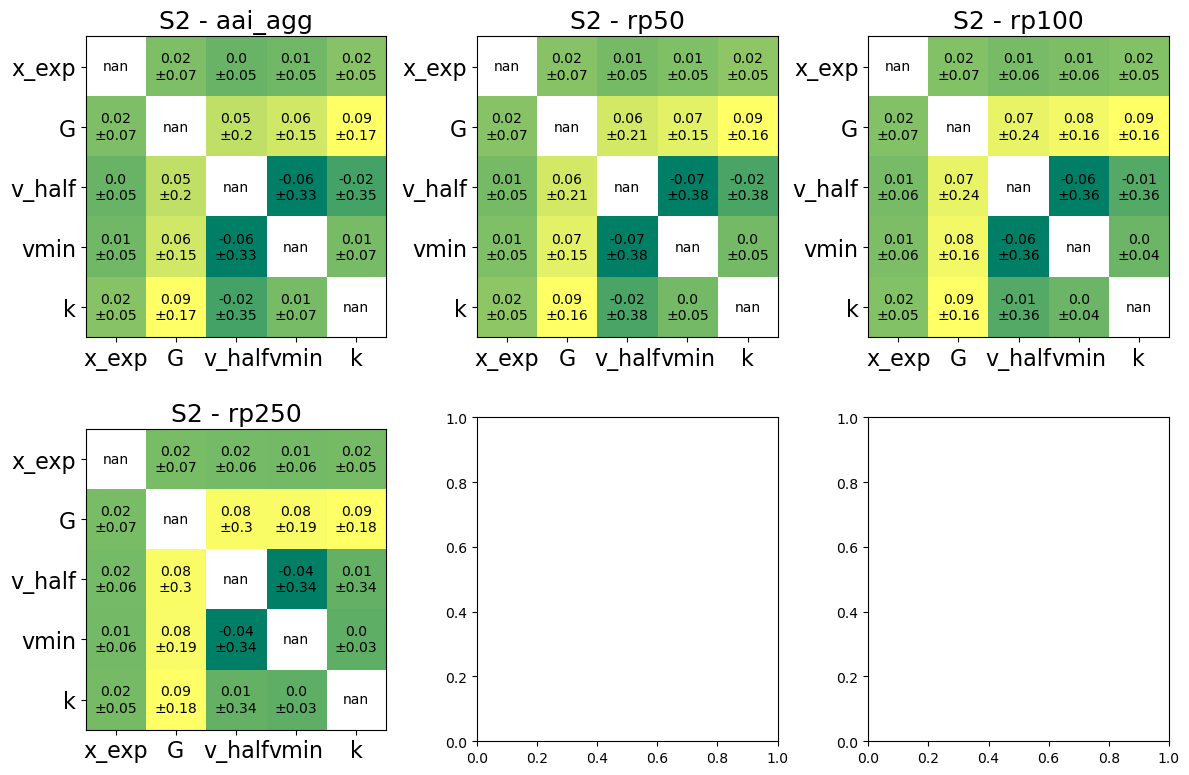

In [39]:
output_imp.plot_sensitivity_second_order(figsize=(12, 8));

<a id="a-few-non-default-parameters"></a>
### A few non-default parameters


We shall use the same uncertainty variables as in the previous section but show a few possibilities to use non-default method arguments.

In [40]:
# Sampling method "latin" hypercube instead of `saltelli`.
from climada.engine.unsequa import CalcImpact

calc_imp2 = CalcImpact(exp_iv, impf_iv, haz)
output_imp2 = calc_imp2.make_sample(N=1000, sampling_method="latin")

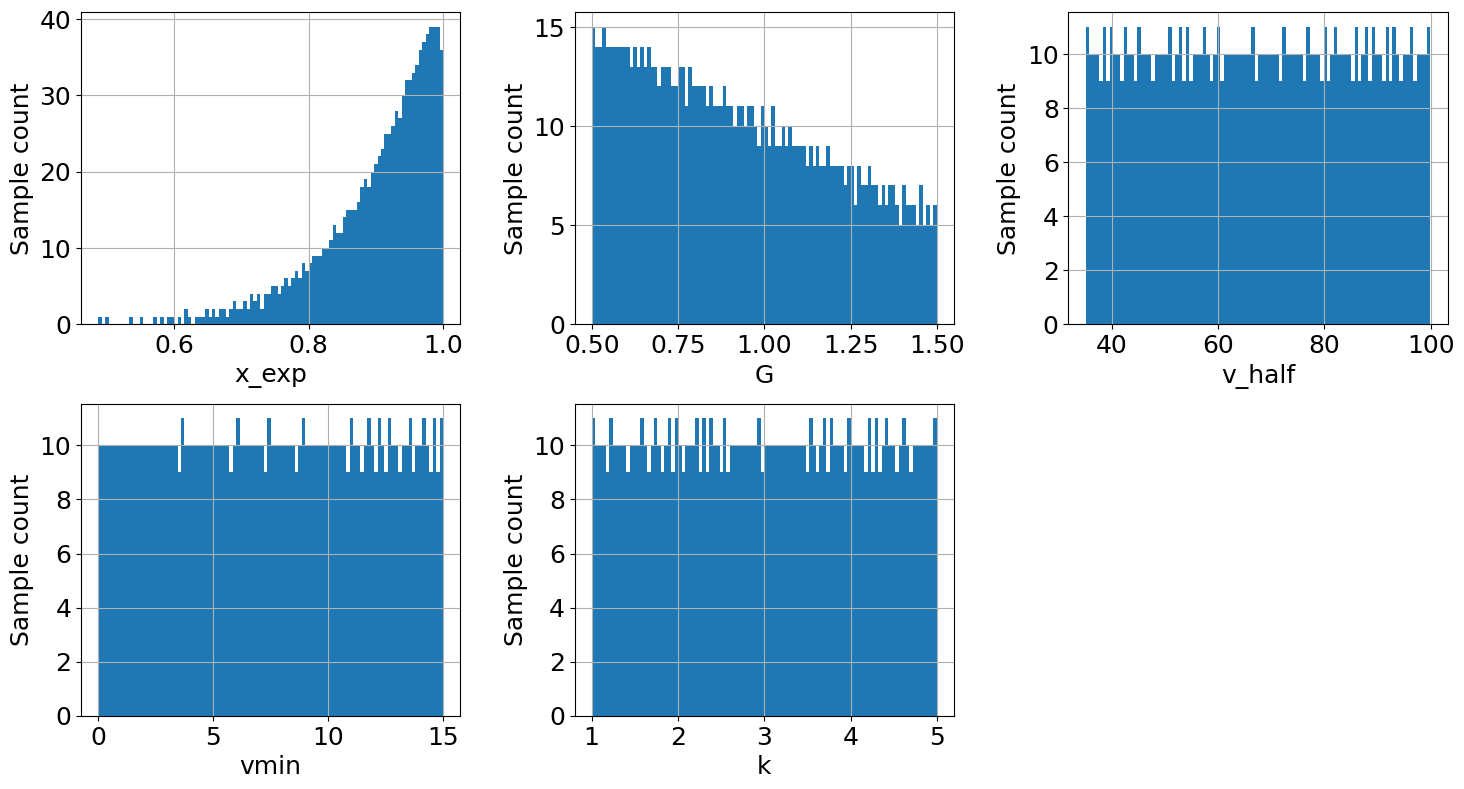

In [41]:
output_imp2.plot_sample(figsize=(15, 8));

In [42]:
# Compute also the distribution of the metric `eai_exp`
# To speed-up the comutations, we can use more than one process
# Note that for large dataset a single process might be more efficient
import time

calc_imp2 = CalcImpact(exp_iv, impf_iv, haz)
output_imp2 = calc_imp2.make_sample(N=1000, sampling_method="latin")

start = time.time()
output_imp2 = calc_imp2.uncertainty(
    output_imp2, rp=[50, 100, 250], calc_eai_exp=True, calc_at_event=True, processes=4
)
end = time.time()
time_passed = end - start
print(f"Time passed with pool: {time_passed}")

Time passed with pool: 2.8349649906158447


In [43]:
from climada.engine.unsequa import CalcImpact
import time

In [44]:
calc_imp2 = CalcImpact(exp_iv, impf_iv, haz)
output_imp2 = calc_imp2.make_sample(N=1000, sampling_method="latin")

start2 = time.time()
output_imp2 = calc_imp2.uncertainty(
    output_imp2, rp=[50, 100, 250], calc_eai_exp=True, calc_at_event=True
)
end2 = time.time()
time_passed_nopool = end2 - start2
print(f"Time passed without pool: {time_passed_nopool}")

Time passed without pool: 8.287853956222534


In [45]:
# Add the original value of the impacts (without uncertainty) to the uncertainty plot
from climada.engine import ImpactCalc

imp = ImpactCalc(exp_base, impf_func(), haz).impact(assign_centroids=False)
aai_agg_o = imp.aai_agg
freq_curve_o = imp.calc_freq_curve([50, 100, 250]).impact
orig_list = [aai_agg_o] + list(freq_curve_o) + [1]

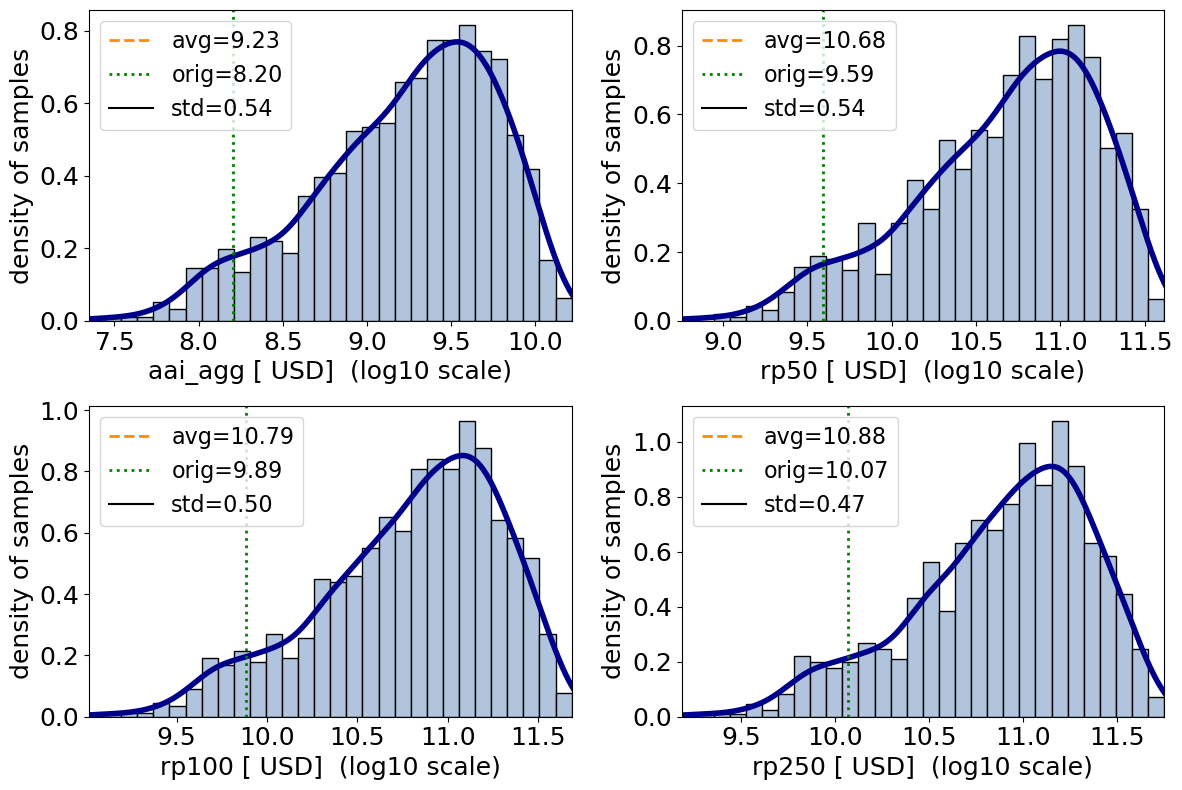

In [46]:
# plot the aai_agg and freq_curve uncertainty only
# use logarithmic x-scale
output_imp2.plot_uncertainty(
    metric_list=["aai_agg", "freq_curve"],
    orig_list=orig_list,
    log=True,
    figsize=(12, 8),
);

In [47]:
# Use the method 'rbd_fast' which is recommend in pair with 'latin'. In addition, change one of the kwargs
# (M=15) of the salib sampling method.
output_imp2 = calc_imp2.sensitivity(
    output_imp2, sensitivity_method="rbd_fast", sensitivity_kwargs={"M": 15}
)

Since we computed the distribution and sensitivity indices for the total impact at each exposure point, we can plot a map of the largest sensitivity index in each exposure location. For every location, the most sensitive parameter is `v_half`, meaning that the average annual impact at each location is most sensitivity to the ucnertainty in the impact function slope scaling parameter.

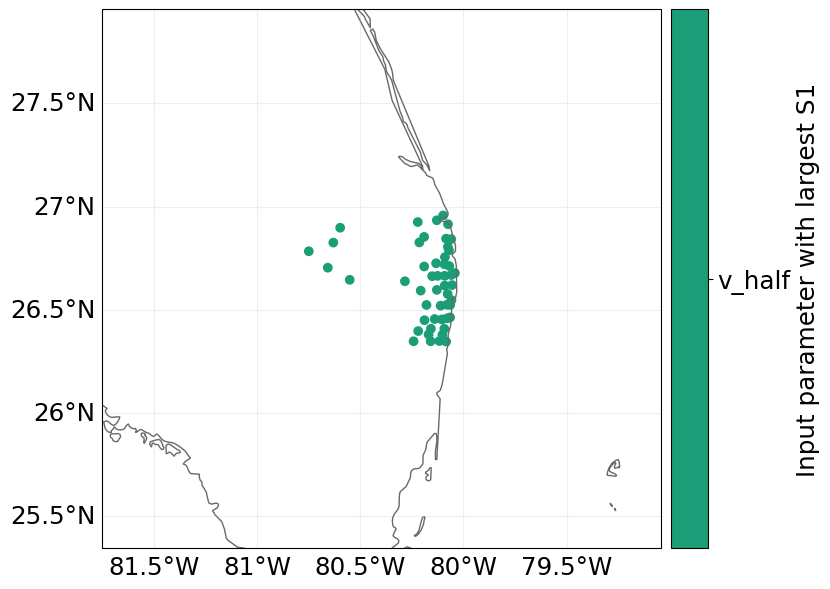

In [48]:
output_imp2.plot_sensitivity_map();

In [49]:
output_imp2.get_largest_si(salib_si="S1", metric_list=["eai_exp"]).tail()

,metric,param,param2,si
45,45,v_half,None,0.471587
46,46,v_half,None,0.471587
47,47,v_half,None,0.471587
48,48,v_half,None,0.467530
49,49,v_half,None,0.471587


<a id="calcdeltaimpact"></a>
## CalcDeltaImpact


The main goal of this class is to perform an uncertainty and sensitivity analysis of the "delta" impact between a reference state and future (or any other "to be compared") state.

Classical example: risk increase in the future with climate change and socio economic development. In this case, the uncertainty and sensitivity analysis in performed on the estimated risk (delta) increase in the future relative to the present-day baseline.

The uncertainty and sensitivity analysis for CalcDeltaImpact is completely analogous to the Impact case. It is slightly more complex as there are more input variables.

Note, the logic of this class works with any comparison between an initial (reference and final (altered) risk or impact state and is not limited to the scope of climate change and socio-economic development in the future.

<a id="set-the-input-vars"></a>
### Set the Input Vars


We'll work through an analogous example as in CalcImpact next.

In [50]:
import numpy as np

from climada.entity import ImpactFunc, ImpactFuncSet, Exposures
from climada.util.constants import EXP_DEMO_H5, HAZ_DEMO_H5
from climada.hazard import Centroids, TCTracks, Hazard, TropCyclone


def impf_func(G=1, v_half=84.7, vmin=25.7, k=3, _id=1):

    def xhi(v, v_half, vmin):
        return max([(v - vmin), 0]) / (v_half - vmin)

    def sigmoid_func(v, G, v_half, vmin, k):
        return G * xhi(v, v_half, vmin) ** k / (1 + xhi(v, v_half, vmin) ** k)

    # In-function imports needed only for parallel computing on Windows
    intensity_unit = "m/s"
    intensity = np.linspace(0, 150, num=100)
    mdd = np.repeat(1, len(intensity))
    paa = np.array([sigmoid_func(v, G, v_half, vmin, k) for v in intensity])
    imp_fun = ImpactFunc("TC", _id, intensity, mdd, paa, intensity_unit)
    imp_fun.check()
    impf_set = ImpactFuncSet([imp_fun])
    return impf_set

Load the hazard set and apply climate change factors to it. This yields a hazard representation in 2050 under 4 RCP scenarios. For a full documentation of this function please refer to the [TropCyclone](climada_hazard_TropCyclone.ipynb) tutorial.

In [51]:
# load historical hazard set
haz = TropCyclone.from_hdf5(HAZ_DEMO_H5)
haz.basin = ["NA"] * haz.size

# apply climate change factors
haz_26 = haz.apply_climate_scenario_knu(ref_year=2050, rcp_scenario=26)
haz_45 = haz.apply_climate_scenario_knu(ref_year=2050, rcp_scenario=45)
haz_60 = haz.apply_climate_scenario_knu(ref_year=2050, rcp_scenario=60)
haz_85 = haz.apply_climate_scenario_knu(ref_year=2050, rcp_scenario=85)

# pack future hazard sets into dictionary - we want to sample from this dictionary later
haz_fut_list = [haz_26, haz_45, haz_60, haz_85]
tc_haz_fut_dict = {}
for r, rcp in enumerate(["26", "45", "60", "85"]):
    tc_haz_fut_dict[rcp] = haz_fut_list[r]

In [52]:
exp_base = Exposures.from_hdf5(EXP_DEMO_H5)
# It is a good idea to assign the centroids to the base exposures in order to avoid repeating this
# potentially costly operation for each sample.
exp_base.assign_centroids(haz)


def exp_base_func(x_exp, exp_base):
    exp = exp_base.copy()
    exp.gdf["value"] *= x_exp
    return exp


from functools import partial

exp_func = partial(exp_base_func, exp_base=exp_base)

In [53]:
import scipy as sp
from climada.engine.unsequa import InputVar

exp_distr = {
    "x_exp": sp.stats.beta(10, 1.1)
}  # This is not really a reasonable distribution but is used
# here to show that you can use any scipy distribution.

exp_iv = InputVar(exp_func, exp_distr)

impf_distr = {
    "G": sp.stats.truncnorm(0.5, 1.5),
    "v_half": sp.stats.uniform(35, 65),
    "vmin": sp.stats.uniform(0, 15),
    "k": sp.stats.uniform(1, 4),
}
impf_iv = InputVar(impf_func, impf_distr)

Next we define the function for the future hazard representation. It's a simple function that allows us to draw from the hazard dictionary of hazard sets under different RCP scenarios. Note, we do not investigate other hazard related uncertainties in this example.

In [54]:
rcp_key = {0: "26", 1: "45", 2: "60", 3: "85"}


# future
def haz_fut_func(rcp_scenario):
    haz_fut = tc_haz_fut_dict[rcp_key[rcp_scenario]]
    return haz_fut


haz_fut_distr = {"rcp_scenario": sp.stats.randint(0, 4)}

haz_fut_iv = InputVar(haz_fut_func, haz_fut_distr)

<a id="compute-uncertainty-and-sensitivity"></a>
### Compute uncertainty and sensitivity


In contrast to CalcImpact, we define InputVars for initial and final states of exposure, impact function, hazard. This class requires 6 input variables. For the sake of simplicity, we did not define varying input variables for the initial and future exposure and vulernability in the example. Hence, the exp_iv and impf_iv are passed to CalcDeltaImpact twice.

In [55]:
from climada.engine.unsequa import CalcDeltaImpact

calc_imp = CalcDeltaImpact(exp_iv, impf_iv, haz, exp_iv, impf_iv, haz_fut_iv)

2024-01-25 15:36:53,385 - climada.engine.unsequa.calc_base - WARNING - 

The input parameter x_exp is shared among at least 2 input variables. Their uncertainty is thus computed with the same samples for this input paramter.


2024-01-25 15:36:53,389 - climada.engine.unsequa.calc_base - WARNING - 

The input parameter G is shared among at least 2 input variables. Their uncertainty is thus computed with the same samples for this input paramter.


2024-01-25 15:36:53,390 - climada.engine.unsequa.calc_base - WARNING - 

The input parameter v_half is shared among at least 2 input variables. Their uncertainty is thus computed with the same samples for this input paramter.


2024-01-25 15:36:53,393 - climada.engine.unsequa.calc_base - WARNING - 

The input parameter vmin is shared among at least 2 input variables. Their uncertainty is thus computed with the same samples for this input paramter.


2024-01-25 15:36:53,394 - climada.engine.unsequa.calc_base - WARNING - 

The input parameter k i

In [56]:
output_imp = calc_imp.make_sample(N=2**7)
output_imp.get_samples_df().tail()

output_imp = calc_imp.uncertainty(output_imp)

Plotting functionalities work analogous to CalcImpact. By setting `calc_delta=True`, the axis labels are adjusted.

No data to plot for 'rp5'.
No data to plot for 'rp10'.


array([[<Axes: xlabel='aai_agg change [%]', ylabel='density of samples'>,
        <Axes: xlabel='rp5', ylabel='density of samples'>],
       [<Axes: xlabel='rp10', ylabel='density of samples'>,
        <Axes: xlabel='rp20 change [%]', ylabel='density of samples'>],
       [<Axes: xlabel='rp50 change [%]', ylabel='density of samples'>,
        <Axes: xlabel='rp100 change [%]', ylabel='density of samples'>],
       [<Axes: xlabel='rp250 change [%]', ylabel='density of samples'>,
        <Axes: >]], dtype=object)

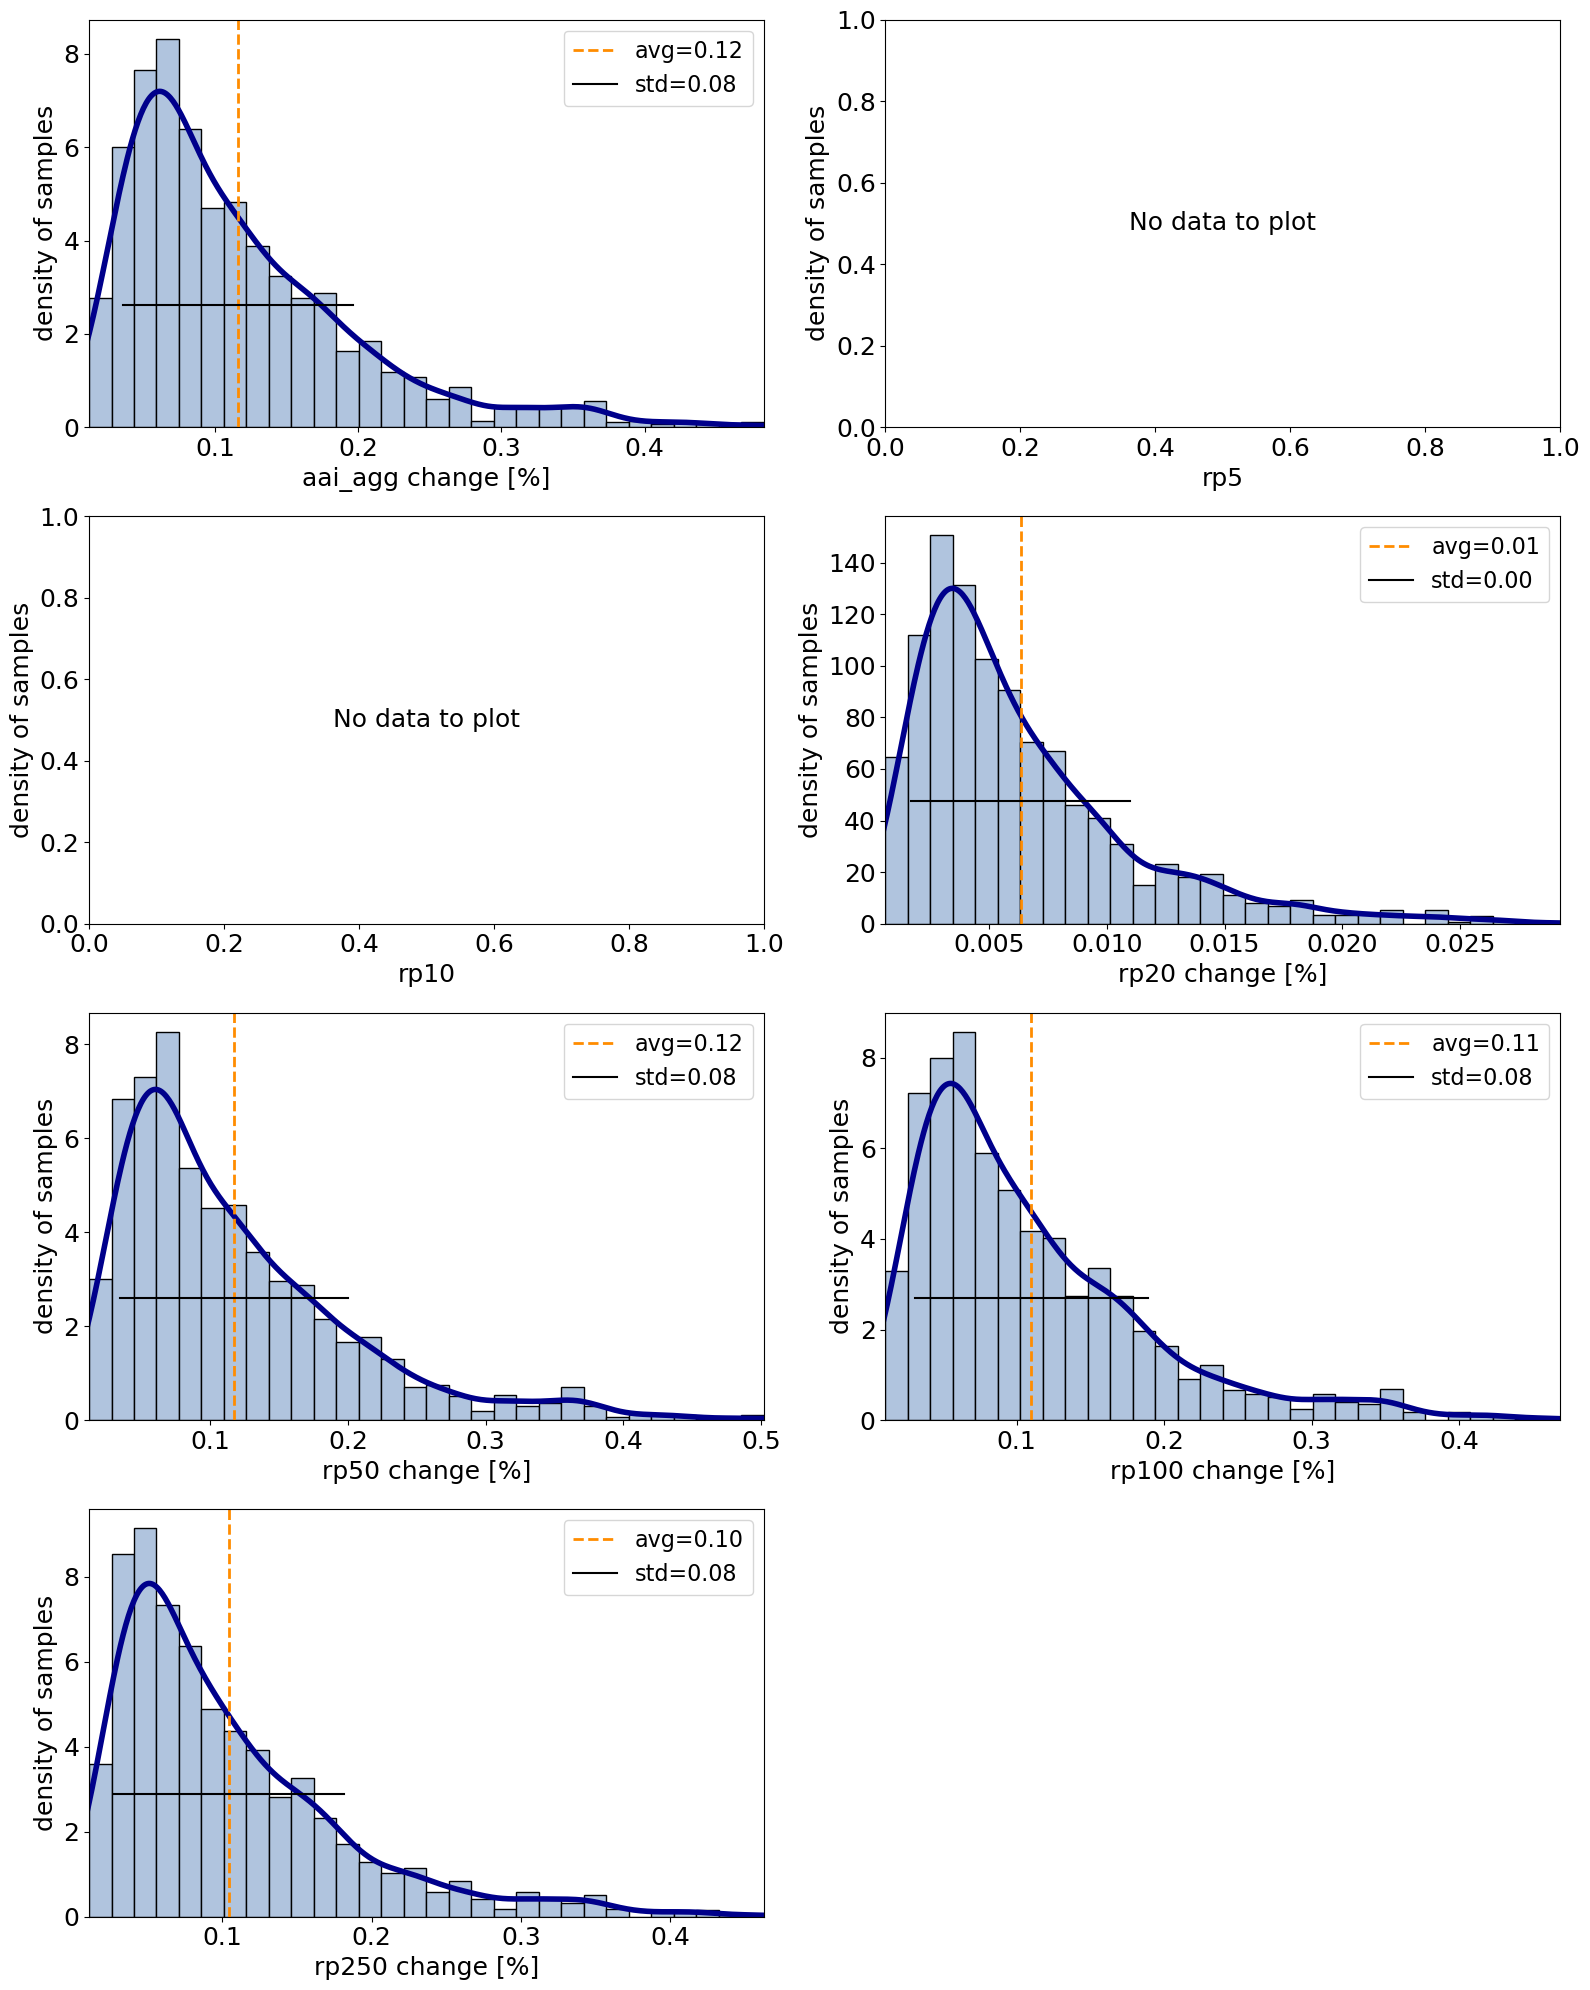

In [57]:
from climada.engine.unsequa import UncOutput

output_imp.plot_uncertainty(calc_delta=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Skipping plot for 'rp5': insufficient data.
Skipping plot for 'rp10': insufficient data.


array([<Axes: xlabel='Impact change [%]', ylabel='Return period [years]'>,
       <Axes: xlabel='Return period [year]', ylabel='Impact change [%]'>],
      dtype=object)

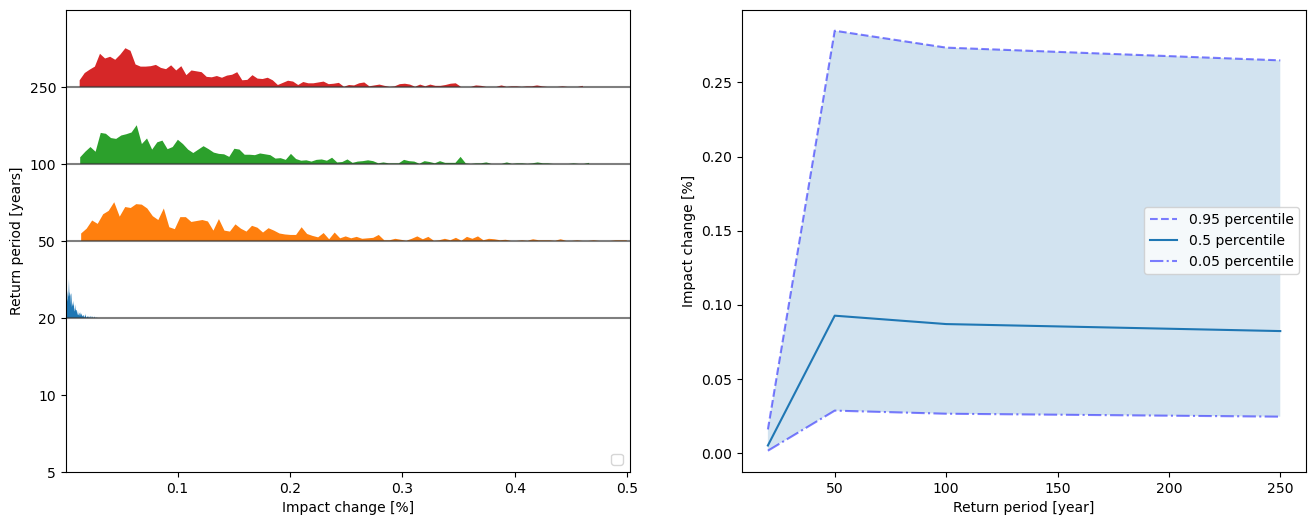

In [58]:
from climada.engine.unsequa import UncOutput

output_imp.plot_rp_uncertainty(calc_delta=True)

In [59]:
# compute sensitivity
output_imp = calc_imp.sensitivity(output_imp)

2024-01-25 15:37:27,753 - climada.engine.unsequa.unc_output - WARNING - All-NaN columns encountered: ['rp5', 'rp10']


array([<Axes: xlabel='Input parameter', ylabel='S1'>,
       <Axes: xlabel='Input parameter', ylabel='S1'>], dtype=object)

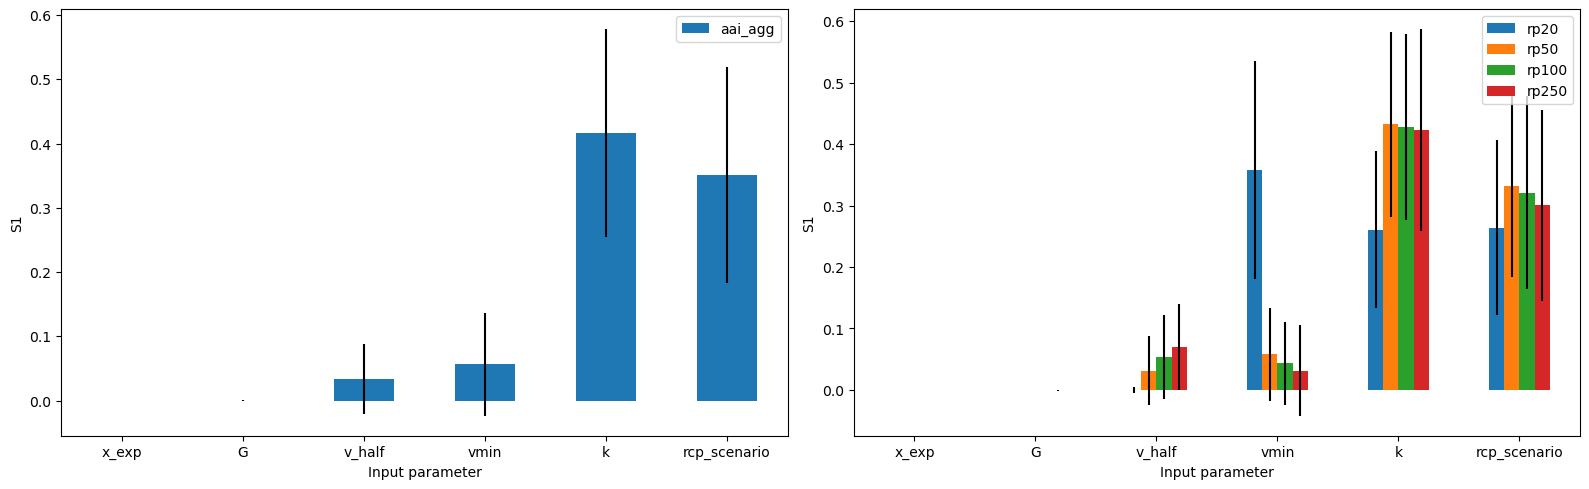

In [60]:
# plot sensitivity
output_imp.plot_sensitivity()

The rest of the functionalities that apply to CalcImpact also work for the CalcDeltaImpact class. Hence, refer to the sections above for details.

<a id="calccostbenefit"></a>
## CalcCostBenefit


The uncertainty and sensitivity analysis for CostBenefit is completely analogous to the Impact case. It is slightly more complex as there are more input variables.

<a id="set-the-input-vars"></a>
### Set the Input Vars


In [61]:
import copy
from climada.util.constants import ENT_DEMO_TODAY, ENT_DEMO_FUTURE, HAZ_DEMO_H5
from climada.entity import Entity
from climada.hazard import Hazard


# Entity today has an uncertainty in the total asset value
def ent_today_func(x_ent):
    # In-function imports needed only for parallel computing on Windows
    from climada.entity import Entity
    from climada.util.constants import ENT_DEMO_TODAY

    entity = Entity.from_excel(ENT_DEMO_TODAY)
    entity.exposures.ref_year = 2018
    entity.exposures.gdf["value"] *= x_ent
    return entity


# Entity in the future has a +- 10% uncertainty in the cost of all the adapatation measures
def ent_fut_func(m_fut_cost):
    # In-function imports needed only for parallel computing on Windows
    from climada.entity import Entity
    from climada.util.constants import ENT_DEMO_FUTURE

    entity = Entity.from_excel(ENT_DEMO_FUTURE)
    entity.exposures.ref_year = 2040
    for meas in entity.measures.get_measure("TC"):
        meas.cost *= m_fut_cost
    return entity


haz_base = Hazard.from_hdf5(HAZ_DEMO_H5)


# The hazard intensity in the future is also uncertainty by a multiplicative factor
def haz_fut(x_haz_fut, haz_base):
    # In-function imports needed only for parallel computing on Windows
    import copy
    from climada.hazard import Hazard
    from climada.util.constants import HAZ_DEMO_H5

    haz = copy.deepcopy(haz_base)
    haz.intensity = haz.intensity.multiply(x_haz_fut)
    return haz


from functools import partial

haz_fut_func = partial(haz_fut, haz_base=haz_base)

Check that costs for measures are changed as desired.

In [62]:
costs_1 = [meas.cost for meas in ent_fut_func(1).measures.get_measure("TC")]
costs_05 = [meas.cost for meas in ent_fut_func(0.5).measures.get_measure("TC")]
print(
    f"\nThe cost for m_fut_cost=1 are {costs_1}\n"
    f"The cost for m_fut_cost=0.5 are {costs_05}"
);


The cost for m_fut_cost=1 are [1311768360.8515418, 1728000000.0, 8878779433.630093, 9200000000.0]
The cost for m_fut_cost=0.5 are [655884180.4257709, 864000000.0, 4439389716.815046, 4600000000.0]


Define the InputVars

In [63]:
import scipy as sp
from climada.engine.unsequa import InputVar

haz_today = haz_base

haz_fut_distr = {
    "x_haz_fut": sp.stats.uniform(1, 3),
}
haz_fut_iv = InputVar(haz_fut_func, haz_fut_distr)

ent_today_distr = {"x_ent": sp.stats.uniform(0.7, 1)}
ent_today_iv = InputVar(ent_today_func, ent_today_distr)

ent_fut_distr = {"m_fut_cost": sp.stats.norm(1, 0.1)}
ent_fut_iv = InputVar(ent_fut_func, ent_fut_distr)

In [64]:
ent_avg = ent_today_iv.evaluate()
ent_avg.exposures.gdf.head()

,latitude,longitude,value,deductible,cover,impf_TC,Value_2010
0,26.933899,-80.128799,1.671301e+10,0,1.392750e+10,1,5.139301e+09
1,26.957203,-80.098284,1.511528e+10,0,1.259606e+10,1,4.647994e+09
2,26.783846,-80.748947,1.511528e+10,0,1.259606e+10,1,4.647994e+09
3,26.645524,-80.550704,1.511528e+10,0,1.259606e+10,1,4.647994e+09
4,26.897796,-80.596929,1.511528e+10,0,1.259606e+10,1,4.647994e+09


<a id="compute-cost-benefit-uncertainty-and-sensitivity-using-default-methods"></a>
### Compute cost benefit uncertainty and sensitivity using default methods


For examples of how to use non-defaults please see the [impact example](#compute-uncertainty-and-sensitivity-using-default-methods)

In [65]:
from climada.engine.unsequa import CalcCostBenefit

unc_cb = CalcCostBenefit(
    haz_input_var=haz_today,
    ent_input_var=ent_today_iv,
    haz_fut_input_var=haz_fut_iv,
    ent_fut_input_var=ent_fut_iv,
)

In [66]:
output_cb = unc_cb.make_sample(N=10, sampling_kwargs={"calc_second_order": False})
output_cb.get_samples_df().tail()

,x_ent,x_haz_fut,m_fut_cost
45,1.35625,2.96875,0.813727
46,1.04375,2.96875,0.813727
47,1.35625,2.03125,0.813727
48,1.35625,2.96875,0.899001
49,1.04375,2.03125,0.899001


For longer computations, it is possible to use a pool for parallel computation.

In [67]:
# without pool
output_cb = unc_cb.uncertainty(output_cb)

# with pool
output_cb = unc_cb.uncertainty(output_cb, processes=4)


Measure              Cost (USD bn)    Benefit (USD bn)    Benefit/Cost
-----------------  ---------------  ------------------  --------------
Mangroves                  1.30148           13.8606        10.6498
Beach nourishment          1.71445           10.7904         6.29377
Seawall                    8.80916            0.175596       0.0199334
Building code              9.12786           29.4038         3.22132

--------------------  --------  --------
Total climate risk:   117.615   (USD bn)
Average annual risk:   13.6166  (USD bn)
Residual risk:         63.3848  (USD bn)
--------------------  --------  --------
Net Present Values

Measure              Cost (USD bn)    Benefit (USD bn)    Benefit/Cost
-----------------  ---------------  ------------------  --------------
Mangroves                  1.30148           13.8606        10.6498
Beach nourishment          1.71445           10.7904         6.29377
Seawall                    8.80916            0.175596       0.0199334
Buil


Measure              Cost (USD bn)    Benefit (USD bn)    Benefit/Cost
-----------------  ---------------  ------------------  --------------
Mangroves                  1.20992           12.8863        10.6505
Beach nourishment          1.59383            9.98362        6.2639
Seawall                    8.18941            0.257712       0.0314689
Building code              8.48569           33.7244         3.97427

--------------------  --------  --------
Total climate risk:   134.898   (USD bn)
Average annual risk:   15.5605  (USD bn)
Residual risk:         78.0457  (USD bn)
--------------------  --------  --------
Net Present Values

Measure              Cost (USD bn)    Benefit (USD bn)    Benefit/Cost
-----------------  ---------------  ------------------  --------------
Mangroves                  1.20992          10.5404         8.71168
Beach nourishment          1.59383           8.59532        5.39285
Seawall                    8.18941           0.0184996      0.00225897
Buildi


Measure              Cost (USD bn)    Benefit (USD bn)    Benefit/Cost
-----------------  ---------------  ------------------  --------------
Mangroves                  1.259             10.4834         8.32677
Beach nourishment          1.65849            8.23954        4.96809
Seawall                    8.52163            0.415328       0.0487381
Building code              8.82993           36.8908         4.17793

--------------------  --------  --------
Total climate risk:   147.563   (USD bn)
Average annual risk:   17.0232  (USD bn)
Residual risk:         91.5342  (USD bn)
--------------------  --------  --------
Net Present Values

Measure              Cost (USD bn)    Benefit (USD bn)    Benefit/Cost
-----------------  ---------------  ------------------  --------------
Mangroves                  1.259             10.4109         8.26917
Beach nourishment          1.65849            8.18032        4.93239
Seawall                    8.52163            0.415328       0.0487381
Bu


Measure              Cost (USD bn)    Benefit (USD bn)    Benefit/Cost
-----------------  ---------------  ------------------  --------------
Mangroves                  1.34288             7.63243        5.68361
Beach nourishment          1.76899             5.87772        3.32264
Seawall                    9.08939             1.82863        0.201183
Building code              9.41823            44.9771         4.77554

--------------------  -------  --------
Total climate risk:   179.909  (USD bn)
Average annual risk:   20.855  (USD bn)
Residual risk:        119.593  (USD bn)
--------------------  -------  --------
Net Present Values

Measure              Cost (USD bn)    Benefit (USD bn)    Benefit/Cost
-----------------  ---------------  ------------------  --------------
Mangroves                  1.34288           15.0245        11.1883
Beach nourishment          1.76899           11.8507         6.69911
Seawall                    9.08939            0.108627       0.0119509
Build


Measure              Cost (USD bn)    Benefit (USD bn)    Benefit/Cost
-----------------  ---------------  ------------------  --------------
Mangroves                  1.30148           13.8606        10.6498
Beach nourishment          1.71445           10.7904         6.29377
Seawall                    8.80916            0.175596       0.0199334
Building code              9.12786           29.4038         3.22132


--------------------  --------  --------
Total climate risk:   117.615   (USD bn)
Average annual risk:   13.6166  (USD bn)
Residual risk:         63.3848  (USD bn)
--------------------  --------  --------
Measure              Cost (USD bn)    Benefit (USD bn)    Benefit/Cost
-----------------  ---------------  ------------------  --------------
Mangroves                  1.20992          10.5404         8.71168
Beach nourishment          1.59383           8.59532        5.39285
Seawall                    8.18941           0.0184996      0.00225897
Building code           

--------------------  --------  --------
Net Present Values


Measure              Cost (USD bn)    Benefit (USD bn)    Benefit/Cost
-----------------  ---------------  ------------------  --------------
Mangroves                  1.38774            8.47373        6.10615
Beach nourishment          1.82807            6.47644        3.54276
Seawall                    9.39298            0.895618       0.0953497
Building code              9.7328            41.4191         4.25562Measure              Cost (USD bn)    Benefit (USD bn)    Benefit/Cost
-----------------  ---------------  ------------------  --------------
Mangroves                  1.259              8.71881        6.92518
Beach nourishment          1.65849            6.76247        4.07748
Seawall                    8.52163            0.621468       0.0729283
Building code              8.82993           39.286          4.44919



--------------------  --------  --------
Total climate risk:   165.676   (USD bn)
Average annual

--------------------  -------  --------
--------------------  --------  --------
Total climate risk:   172.667   (USD bn)
Average annual risk:   20.0179  (USD bn)
Residual risk:        114.941   (USD bn)
--------------------  --------  --------

Net Present Values

--------------------  --------  --------
Total climate risk:   14.4422   (USD bn)
Average annual risk:   1.57569  (USD bn)
Residual risk:         1.0186   (USD bn)
--------------------  --------  --------Net Present Values

Net Present Values

Measure              Cost (USD bn)    Benefit (USD bn)    Benefit/Cost
-----------------  ---------------  ------------------  --------------
Mangroves                  1.17928            8.67047        7.35233
Beach nourishment          1.55347            6.72299        4.32772
Seawall                    7.98203            0.621468       0.0778584
Building code              8.27081           39.2619         4.74705

--------------------  --------  --------
Total climate risk:   157.04

The output of `CostBenefit.calc` is rather complex in its structure. The metrics dictionary inherits this complexity.

In [68]:
# Top level metrics keys
macro_metrics = output_cb.uncertainty_metrics
macro_metrics

['imp_meas_present',
 'imp_meas_future',
 'tot_climate_risk',
 'benefit',
 'cost_ben_ratio']

In [69]:
# The benefits and cost_ben_ratio are available for each measure
output_cb.get_uncertainty(metric_list=["benefit", "cost_ben_ratio"]).tail()

,Mangroves Benef,Beach nourishment Benef,Seawall Benef,Building code Benef,Mangroves CostBen,Beach nourishment CostBen,Seawall CostBen,Building code CostBen
45,8.670468e+09,6.722992e+09,6.214684e+08,3.926190e+10,0.123110,0.209151,11.625533,0.190676
46,8.549601e+09,6.624301e+09,6.214684e+08,3.920155e+10,0.124850,0.212267,11.625533,0.190969
47,1.455086e+10,1.152385e+10,6.206260e+07,1.901856e+10,0.073358,0.122018,116.413127,0.393631
48,8.670468e+09,6.722992e+09,6.214684e+08,3.926190e+10,0.136011,0.231069,12.843826,0.210657
49,1.443000e+10,1.142516e+10,6.206260e+07,1.895821e+10,0.081724,0.135970,128.612593,0.436265


In [70]:
# The impact_meas_present and impact_meas_future provide values of the cost_meas, risk_transf, risk,
# and cost_ins for each measure
output_cb.get_uncertainty(metric_list=["imp_meas_present"]).tail()

,no measure - risk - present,no measure - risk_transf - present,no measure - cost_meas - present,no measure - cost_ins - present,Mangroves - risk - present,Mangroves - risk_transf - present,Mangroves - cost_meas - present,Mangroves - cost_ins - present,Beach nourishment - risk - present,Beach nourishment - risk_transf - present,Beach nourishment - cost_meas - present,Beach nourishment - cost_ins - present,Seawall - risk - present,Seawall - risk_transf - present,Seawall - cost_meas - present,Seawall - cost_ins - present,Building code - risk - present,Building code - risk_transf - present,Building code - cost_meas - present,Building code - cost_ins - present
45,1.040893e+08,0.0,0,0,5.197409e+07,0,1.311768e+09,1,6.153578e+07,0,1.728000e+09,1,1.040893e+08,0,8.878779e+09,1,7.806698e+07,0,9.200000e+09,1
46,8.010560e+07,0.0,0,0,3.999849e+07,0,1.311768e+09,1,4.735703e+07,0,1.728000e+09,1,8.010560e+07,0,8.878779e+09,1,6.007920e+07,0,9.200000e+09,1
47,1.040893e+08,0.0,0,0,5.197409e+07,0,1.311768e+09,1,6.153578e+07,0,1.728000e+09,1,1.040893e+08,0,8.878779e+09,1,7.806698e+07,0,9.200000e+09,1
48,1.040893e+08,0.0,0,0,5.197409e+07,0,1.311768e+09,1,6.153578e+07,0,1.728000e+09,1,1.040893e+08,0,8.878779e+09,1,7.806698e+07,0,9.200000e+09,1
49,8.010560e+07,0.0,0,0,3.999849e+07,0,1.311768e+09,1,4.735703e+07,0,1.728000e+09,1,8.010560e+07,0,8.878779e+09,1,6.007920e+07,0,9.200000e+09,1


We can plot the distributions for the top metrics or our choice.

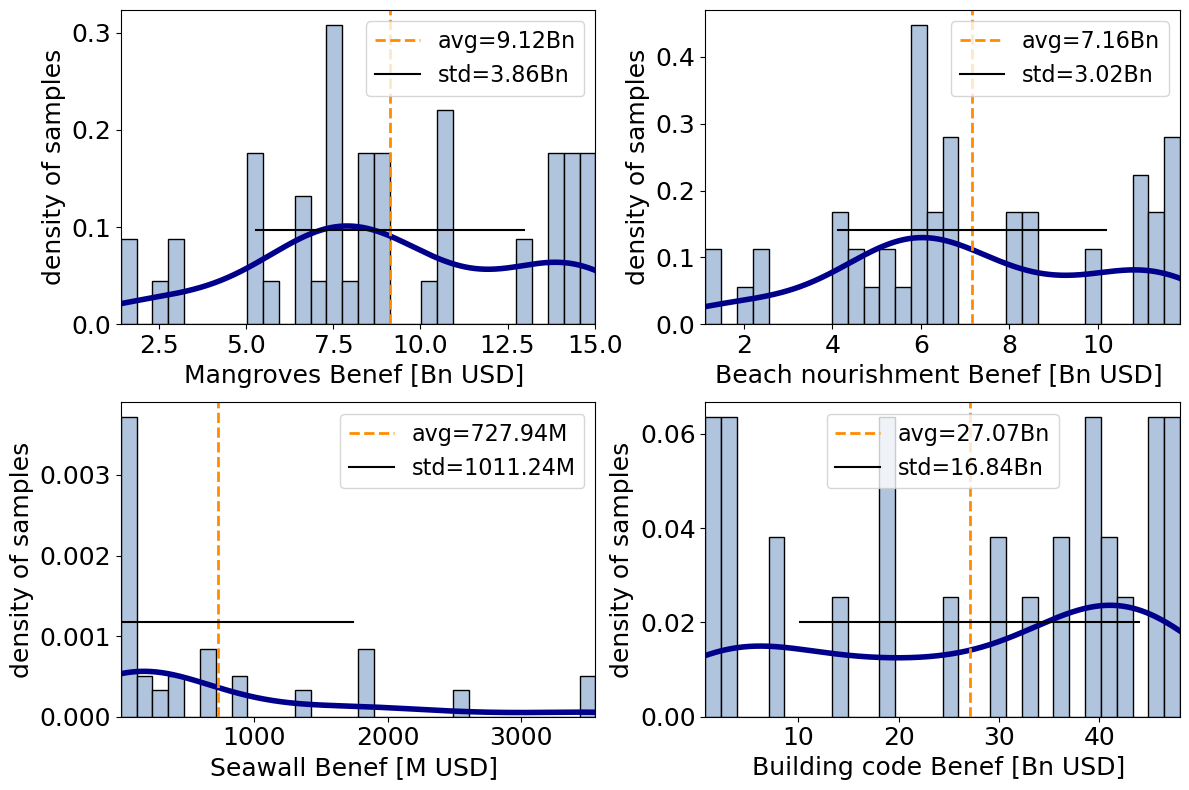

In [71]:
# tot_climate_risk and benefit
output_cb.plot_uncertainty(metric_list=["benefit"], figsize=(12, 8));

Analogously to the impact example, now that we have a metric distribution, we can compute the sensitivity indices. Since we used the default sampling method, we can use the default sensitivity analysis method. However, since we used `calc_second_order = False` for the sampling, we need to specify the same for the sensitivity analysis.

In [72]:
output_cb = unc_cb.sensitivity(
    output_cb, sensitivity_kwargs={"calc_second_order": False}
)

The sensitivity indices can be plotted. For the default method 'sobol', by default the 'S1' sensitivity index is plotted.

Note that since we have quite a few measures, the plot must be adjusted a bit or dropped. Also see that for many metrics, the sensitivity to certain uncertainty parameters appears to be 0. However, this result is to be treated with care. Indeed, we used for demonstration purposes a rather too low number of samples, which is indicated by large confidence intervals (vertical black lines) for most sensitivity indices. For a more robust result the analysis should be repeated with more samples.

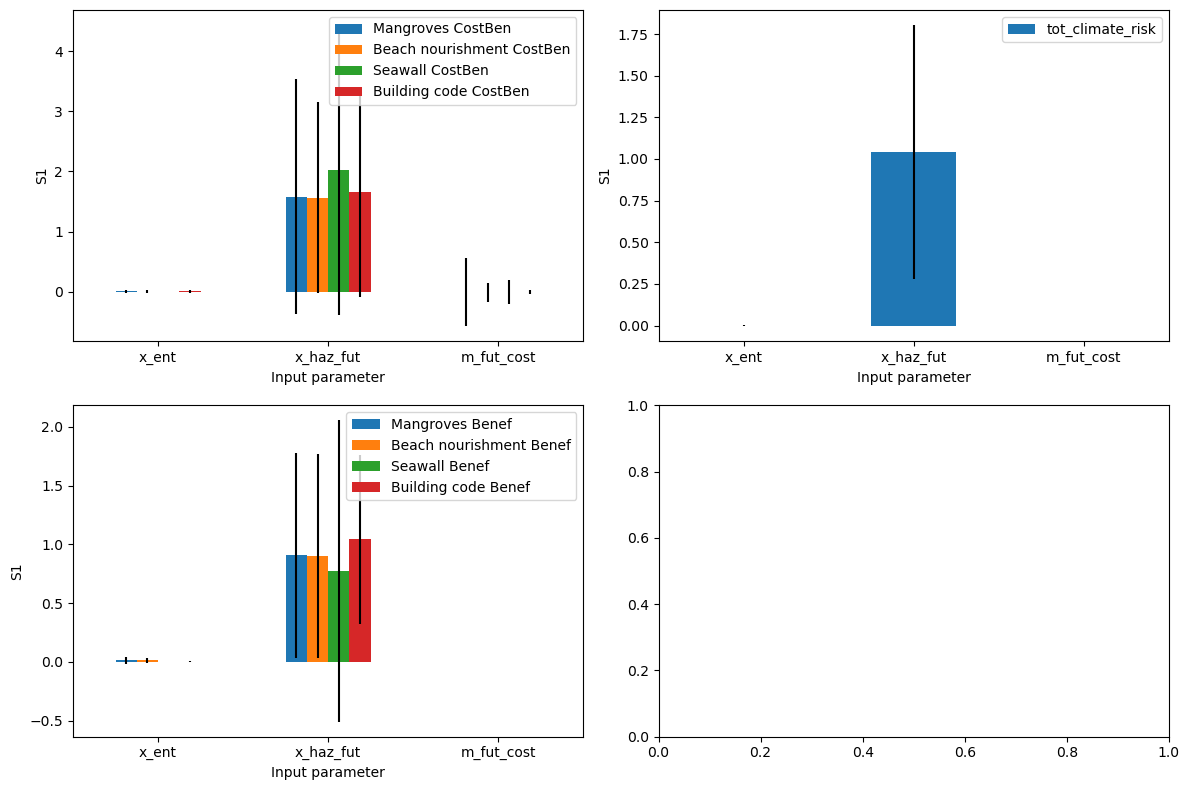

In [73]:
# plot only certain metrics
axes = output_cb.plot_sensitivity(
    metric_list=["cost_ben_ratio", "tot_climate_risk", "benefit"], figsize=(12, 8)
);

<a id="advanced-examples"></a>
## Advanced examples


<a id="coupled-variables"></a>
### Coupled variables


In this example, we show how you can define correlated input variables. Suppose your exposures and hazards are conditioned on the same Shared Socio-economic Pathway (SSP). Then, you want that only exposures and hazard belonging to the same SSP are present in each sample.

In order to achieve this, you must simply define an uncertainty parameter that shares the same name and the same distribution for both the exposures and the hazard uncertainty variables.

<a id="many-scenarios-of-hazards-and-exposures"></a>
#### Many scenarios of hazards and exposures


In this example we look at the case where many scenarios are tested in the uncertainty analysis. For instance, suppose you have data for different Shared Socio-economic Pathways (SSP) and different Climate Change projections. From the SSPs, you have a number of Exposures, saved to files. From the climate projections, you have a number of Hazards, saved to file.

The task is to sample from the SSPs and the Climate change scenarios for the uncertainty and sensitivity analysis efficiently.

For demonstration purposes, we will use below as exposures files the litpop for three countries, and for tha hazard files the winter storms for the same three countries. Instead of having SSPs, we now want to only combine exposures and hazards of the same countries.


In [74]:
from climada.util.api_client import Client

client = Client()

In [75]:
def get_litpop(iso):
    return client.get_litpop(country=iso)


def get_ws(iso):
    properties = {
        "country_iso3alpha": iso,
    }
    return client.get_hazard("storm_europe", properties=properties)

In [76]:
# Define list of exposures and/or of hazard files

exp_list = [get_litpop(iso) for iso in ["CHE", "DEU", "ITA"]]
haz_list = [get_ws(iso) for iso in ["CHE", "DEU", "ITA"]]
for exp, haz in zip(exp_list, haz_list):
    exp.gdf["impf_WS"] = 1
    exp.assign_centroids(haz)

In [77]:
# Define the input variable
from climada.entity import ImpactFuncSet, Exposures
from climada.entity.impact_funcs.storm_europe import ImpfStormEurope
from climada.hazard import Hazard
from climada.engine.unsequa import InputVar
import scipy as sp
import copy


def exp_func(cnt, x_exp, exp_list=exp_list):
    exp = exp_list[int(cnt)].copy()
    exp.gdf["value"] *= x_exp
    return exp


exp_distr = {
    "x_exp": sp.stats.uniform(0.9, 0.2),
    "cnt": sp.stats.randint(
        low=0, high=len(exp_list)
    ),  # use the same parameter name accross input variables
}
exp_iv = InputVar(exp_func, exp_distr)


def haz_func(cnt, i_haz, haz_list=haz_list):
    haz = copy.deepcopy(
        haz_list[int(cnt)]
    )  # use the same parameter name accross input variables
    haz.intensity *= i_haz
    return haz


haz_distr = {
    "i_haz": sp.stats.norm(1, 0.2),
    "cnt": sp.stats.randint(low=0, high=len(haz_list)),
}
haz_iv = InputVar(haz_func, haz_distr)

impf = ImpfStormEurope.from_schwierz()
impf_set = ImpactFuncSet()
impf_set.append(impf)
impf_iv = InputVar.impfset([impf_set], bounds_mdd=[0.9, 1.1])

In [78]:
from climada.engine.unsequa import CalcImpact

calc_imp = CalcImpact(exp_iv, impf_iv, haz_iv)

2024-01-25 15:38:30,713 - climada.engine.unsequa.calc_base - WARNING - 

The input parameter cnt is shared among at least 2 input variables. Their uncertainty is thus computed with the same samples for this input paramter.




In [79]:
output_imp = calc_imp.make_sample(N=2**2, sampling_kwargs={"skip_values": 2**3})

In [80]:
# as we can see, there is only a single input parameter "cnt" to select the country for both the exposures and the hazard
output_imp.samples_df.tail()

,x_exp,cnt,MDD,i_haz
35,0.9875,0.0,1.0375,1.097755
36,1.0625,1.0,1.0375,1.097755
37,1.0625,0.0,0.9375,1.097755
38,1.0625,0.0,1.0375,1.097755
39,1.0625,0.0,1.0375,1.097755


In [ ]:
output_imp = calc_imp.uncertainty(output_imp)

In [ ]:
output_imp.aai_agg_unc_df.tail()

<a id="input-variable-repeated-loading-of-files-made-efficient"></a>
### Input variable: Repeated loading of files made efficient


Loading Hazards or Exposures from file is a rather lengthy operation. Thus, we want to minimize the reading operations, ideally reading each file only once. Simultaneously, Hazard and Exposures can be large in memory, and thus we would like to have at most one of each loaded at a time. Thus, we do not want to use the list capacity from the helper method InputVar.exposures and InputVar.hazard.

For demonstration purposes, we will use below as exposures files the litpop for three countries, and for tha hazard files the winter storms for the same three countries. Note that this does not make a lot of sense for an uncertainty analysis. For your use case, please replace the set of exposures and/or hazard files with meaningful sets, for instance sets of exposures for different resolutions or hazards for different model runs.


In [ ]:
from climada.util.api_client import Client

client = Client()

In [ ]:
def get_litpop_path(iso):
    properties = {
        "country_iso3alpha": iso,
        "res_arcsec": "150",
        "exponents": "(1,1)",
        "fin_mode": "pc",
    }
    litpop_datasets = client.list_dataset_infos(
        data_type="litpop", properties=properties
    )
    ds = litpop_datasets[0]
    download_dir, ds_files = client.download_dataset(ds)
    return ds_files[0]


def get_ws_path(iso):
    properties = {
        "country_iso3alpha": iso,
    }
    hazard_datasets = client.list_dataset_infos(
        data_type="storm_europe", properties=properties
    )
    ds = hazard_datasets[0]
    download_dir, ds_files = client.download_dataset(ds)
    return ds_files[0]

In [ ]:
# Define list of exposures and/or of hazard files

f_exp_list = [get_litpop_path(iso) for iso in ["CHE", "DEU", "ITA"]]
f_haz_list = [get_ws_path(iso) for iso in ["CHE", "DEU", "ITA"]]

In [ ]:
# Define the input variable for the loading files
# The trick is to not reload a file if it is already in memory. This is done using a global variable.
from climada.entity import ImpactFunc, ImpactFuncSet, Exposures
from climada.hazard import Hazard
from climada.engine.unsequa import InputVar
import scipy as sp
import copy


def exp_func(f_exp, x_exp, filename_list=f_exp_list):
    filename = filename_list[int(f_exp)]
    global exp_base
    if "exp_base" in globals():
        if isinstance(exp_base, Exposures):
            if exp_base.gdf["filename"] != str(filename):
                exp_base = Exposures.from_hdf5(filename)
                exp_base.gdf["filename"] = str(filename)
    else:
        exp_base = Exposures.from_hdf5(filename)
        exp_base.gdf["filename"] = str(filename)

    exp = exp_base.copy()
    exp.gdf["value"] *= x_exp
    return exp


exp_distr = {
    "x_exp": sp.stats.uniform(0.9, 0.2),
    "f_exp": sp.stats.randint(low=0, high=len(f_exp_list)),
}
exp_iv = InputVar(exp_func, exp_distr)


def haz_func(f_haz, i_haz, filename_list=f_haz_list):
    filename = filename_list[int(f_haz)]
    global haz_base
    if "haz_base" in globals():
        if isinstance(haz_base, Hazard):
            if haz_base.filename != str(filename):
                haz_base = Hazard.from_hdf5(filename)
                haz_base.filename = str(filename)
    else:
        haz_base = Hazard.from_hdf5(filename)
        haz_base.filename = str(filename)

    haz = copy.deepcopy(haz_base)
    haz.intensity *= i_haz
    return haz


haz_distr = {
    "i_haz": sp.stats.norm(1, 0.2),
    "f_haz": sp.stats.randint(low=0, high=len(f_haz_list)),
}
haz_iv = InputVar(haz_func, haz_distr)


def impf_func(G=1, v_half=84.7, vmin=25.7, k=3, _id=1):

    def xhi(v, v_half, vmin):
        return max([(v - vmin), 0]) / (v_half - vmin)

    def sigmoid_func(v, G, v_half, vmin, k):
        return G * xhi(v, v_half, vmin) ** k / (1 + xhi(v, v_half, vmin) ** k)

    # In-function imports needed only for parallel computing on Windows
    import numpy as np
    from climada.entity import ImpactFunc, ImpactFuncSet

    imp_fun = ImpactFunc()
    imp_fun.haz_type = "WS"
    imp_fun.id = _id
    imp_fun.intensity_unit = "m/s"
    imp_fun.intensity = np.linspace(0, 150, num=100)
    imp_fun.mdd = np.repeat(1, len(imp_fun.intensity))
    imp_fun.paa = np.array(
        [sigmoid_func(v, G, v_half, vmin, k) for v in imp_fun.intensity]
    )
    imp_fun.check()
    impf_set = ImpactFuncSet()
    impf_set.append(imp_fun)
    return impf_set


impf_distr = {
    "G": sp.stats.truncnorm(0.5, 1.5),
    "v_half": sp.stats.uniform(35, 65),
    "vmin": sp.stats.uniform(0, 15),
    "k": sp.stats.uniform(1, 4),
}
impf_iv = InputVar(impf_func, impf_distr)

In [ ]:
from climada.engine.unsequa import CalcImpact

calc_imp = CalcImpact(exp_iv, impf_iv, haz_iv)

Now that the samples have been generated, it is crucial to oder the samples in order to minimize the number of times files have to be loaded. In this case, loading the hazards take more time than loading the exposures. We thus sort first by hazards (which then each have to be loaded one single time), and then by exposures (which have to be each loaded once for each hazard).


In [ ]:
# Ordering of the samples by hazard first and exposures second
output_imp = calc_imp.make_sample(N=2**2, sampling_kwargs={"skip_values": 2**3})
output_imp.order_samples(by=["f_haz", "f_exp"])

We can verify how the samples are ordered. In the graph below, it is confirmed that the hazard are ordered, and thus the hazards will be loaded once each. The exposures on the other changes at most once per hazard.

In [ ]:
import matplotlib.pyplot as plt

e = output_imp.samples_df["f_exp"].values
h = output_imp.samples_df["f_haz"].values

Note that due to the very small number of samples chosen here for illustrative purposes, not all combinations of hazard and exposures are part of the samples. This is due to the nature of the Sobol sequence (default sampling method).


In [ ]:
plt.plot(e, label="exposures")
plt.plot(h, label="hazards")
plt.xlabel("samples")
plt.ylabel("file number")
plt.title("Order of exposures and hazards files in samples")
plt.legend(loc="upper right");

In [ ]:
output_imp = calc_imp.uncertainty(output_imp)